In [ ]:
"""

Date : August 1, 2019

Author : Heather Landry Drexler

This script will develop plots for Supplemental Figure 6 of the nanoCOP manuscript. 

This script takes as input the datasets from the script nanoCOP_intron_pairs_datasets.ipynb  

"""

In [1]:
import numpy as np
import pandas as pd
import pysam
from collections import Counter

import matplotlib.pyplot as plt
import re
% matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import math

import scipy
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

import pybedtools
from pybedtools import BedTool

import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")

In [2]:
def get_pair_splcing_frequencies(intron_pairs_df):

    pair_dict = {}

    for i in range(0,len(intron_pairs_df)):

        read = intron_pairs_df.iloc[i]['read']
        chrom = intron_pairs_df.iloc[i]['chrom']
        int1_start = intron_pairs_df.iloc[i]['int1_start']
        int1_end = intron_pairs_df.iloc[i]['int1_end']
        int2_start = intron_pairs_df.iloc[i]['int2_start']
        int2_end = intron_pairs_df.iloc[i]['int2_end']
        strand = intron_pairs_df.iloc[i]['strand']
        int1_splice = intron_pairs_df.iloc[i]['int1_splice']
        int2_splice = intron_pairs_df.iloc[i]['int2_splice']

        pair_coord = str(chrom)+"_"+str(int1_start)+"_"+str(int1_end)+"_"+str(int2_start)+"_"+str(int2_end)+"_"+str(strand)

        if (strand == "-"):
            x = int1_splice
            int1_splice = int2_splice
            int2_splice = x

        if pair_coord not in pair_dict.keys():

            if (int1_splice=="YES") & (int2_splice=="YES"):
                pair_dict[pair_coord] = [1,0,0,0]

            if (int1_splice=="YES") & (int2_splice=="NO"):
                pair_dict[pair_coord] = [0,1,0,0]

            if (int1_splice=="NO") & (int2_splice=="YES"):
                pair_dict[pair_coord] = [0,0,1,0]

            if (int1_splice=="NO") & (int2_splice=="NO"):
                pair_dict[pair_coord] = [0,0,0,1]

        elif pair_coord in pair_dict.keys():
            if (int1_splice=="YES") & (int2_splice=="YES"):
                pair_dict[pair_coord][0] += 1

            if (int1_splice=="YES") & (int2_splice=="NO"):
                pair_dict[pair_coord][1] += 1

            if (int1_splice=="NO") & (int2_splice=="YES"):
                pair_dict[pair_coord][2] += 1

            if (int1_splice=="NO") & (int2_splice=="NO"):
                pair_dict[pair_coord][3] += 1

    pair_df = pd.DataFrame.from_dict(pair_dict, orient='index')
    pair_df.columns = ['YES_YES','YES_NO','NO_YES','NO_NO']   

    return pair_df
    
    
def get_read_splicing_counts(name, read_junctions):
    
    read_property = []

    # loop through all reads in the dictionary
    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_splice_pattern = set()

        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # only go through genes that have 2 or more introns
            if (len(read_junctions[read][gene]) > 1 ):

                # characterize the number of spliced and unspliced introns in the read
                splice_status = [row[6] for row in read_junctions[read][gene]]
                splice_status_join = '_'.join(splice_status)
                status_count = Counter(splice_status)

                # only process the file if intron pattern hasn't been seen previously
                # for a gene that this read aligns to
                if (splice_status_join not in uniq_splice_pattern):
                    uniq_splice_pattern.add(splice_status_join)

                    spliced_count = status_count['YES']
                    unspliced_count = status_count['NO']

                    if (unspliced_count>1) and (spliced_count==0):
                        read_property.append([read, gene, 'all_unspliced'])

                    if (unspliced_count==0) and (spliced_count>1):
                        read_property.append([read, gene, 'all_spliced'])

                    if (unspliced_count>=1) and (spliced_count>=1):
                        read_property.append([read, gene, 'intermediate'])

    read_splicing_df = pd.DataFrame(read_property)
    read_splicing_df.columns = ['read','gene','splicing_status']        

    count = []
    spliced_count = len(read_splicing_df[read_splicing_df['splicing_status']=='all_spliced'])
    unspliced_count = len(read_splicing_df[read_splicing_df['splicing_status']=='all_unspliced'])
    intermediate_count = len(read_splicing_df[read_splicing_df['splicing_status']=='intermediate'])
    count.append([name, spliced_count, unspliced_count, intermediate_count])

    count_df = pd.DataFrame(count)
    count_df.columns = ['sample','all_spliced','all_unspliced','intermediate']

    return read_splicing_df, count_df


    
    
    

In [3]:
# SUPPLEMENTAL FIGURE 6A - global levels of splicing across reads that span two or more introns

# save dictionary with all intron junctions that a read spans
K562_1_splice_dictionary = np.load('/path/to/K562_1_splicing_dictionary.npy',encoding='latin1').item() 
K562_2_splice_dictionary = np.load('/path/to/K562_2_splicing_dictionary.npy',encoding='latin1').item() 
K562_3_splice_dictionary = np.load('/path/to/K562_3_splicing_dictionary.npy',encoding='latin1').item() 
K562_4_splice_dictionary = np.load('/path/to/K562_4_splicing_dictionary.npy',encoding='latin1').item() 
K562_5a_splice_dictionary = np.load('/path/to/K562_5a_splicing_dictionary.npy',encoding='latin1').item() 
K562_5b_splice_dictionary = np.load('/path/to/K562_5b_splicing_dictionary.npy',encoding='latin1').item() 

BL1184_1_splice_dictionary = np.load('/path/to/BL1184_1_splicing_dictionary.npy',encoding='latin1').item() 
BL1184_2_splice_dictionary = np.load('/path/to/BL1184_2_splicing_dictionary.npy',encoding='latin1').item() 

S2_1a_splice_dictionary = np.load('/path/to/K562_1a_splicing_dictionary.npy',encoding='latin1').item() 
S2_1b_splice_dictionary = np.load('/path/to/K562_1b_splicing_dictionary.npy',encoding='latin1').item() 
S2_2_splice_dictionary = np.load('/path/to/K562_2_splicing_dictionary.npy',encoding='latin1').item() 
S2_3_splice_dictionary = np.load('/path/to/K562_3_splicing_dictionary.npy',encoding='latin1').item() 


In [4]:
# get splicing status and counts
K562_1_splicing_status, K562_1_splicing_counts = get_read_splicing_counts('K562_1',K562_1_splice_dictionary)
K562_2_splicing_status, K562_2_splicing_counts = get_read_splicing_counts('K562_2',K562_2_splice_dictionary)
K562_3_splicing_status, K562_3_splicing_counts = get_read_splicing_counts('K562_3',K562_3_splice_dictionary)
K562_4_splicing_status, K562_4_splicing_counts = get_read_splicing_counts('K562_4',K562_4_splice_dictionary)
K562_5a_splicing_status, K562_5a_splicing_counts = get_read_splicing_counts('K562_5a',K562_5a_splice_dictionary)
K562_5b_splicing_status, K562_5b_splicing_counts = get_read_splicing_counts('K562_5b',K562_5b_splice_dictionary)

K562_splicing_counts = pd.concat([K562_1_splicing_counts, K562_2_splicing_counts, K562_3_splicing_counts, K562_4_splicing_counts, K562_5a_splicing_counts, K562_5b_splicing_counts])


S2_1a_splicing_status, S2_1a_splicing_counts = get_read_splicing_counts('S2_1a',S2_1a_splice_dictionary)
S2_1b_splicing_status, S2_1b_splicing_counts = get_read_splicing_counts('S2_1b',S2_1b_splice_dictionary)
S2_2_splicing_status, S2_2_splicing_counts = get_read_splicing_counts('S2_2',S2_2_splice_dictionary)
S2_3_splicing_status, S2_3_splicing_counts = get_read_splicing_counts('S2_3',S2_3_splice_dictionary)

S2_splicing_counts = pd.concat([S2_1a_splicing_counts, S2_1b_splicing_counts, S2_2_splicing_counts, S2_3_splicing_counts])


In [5]:
K562_splicing_counts['species'] = 'K562'
S2_splicing_counts['species'] = 'S2'

In [6]:
all_splicing_counts = []
all_splicing_counts.append([K562_splicing_counts['species'].iloc[0],K562_splicing_counts['all_unspliced'].sum(),
                           K562_splicing_counts['intermediate'].sum(), K562_splicing_counts['all_spliced'].sum()])
all_splicing_counts.append([S2_splicing_counts['species'].iloc[0],S2_splicing_counts['all_unspliced'].sum(),
                           S2_splicing_counts['intermediate'].sum(), S2_splicing_counts['all_spliced'].sum()])

all_splicing_counts_df = pd.DataFrame(all_splicing_counts)
all_splicing_counts_df.columns = ['species','all_unspliced','intermediate','all_spliced']


In [7]:
all_splicing_counts_df

,species,all_unspliced,intermediate,all_spliced
0,K562,16912,4995,4867
1,S2,15734,4786,7217


In [8]:

df1 = all_splicing_counts_df.copy()
df2 = all_splicing_counts_df.copy()

df2['all_spliced'] = df1['all_spliced']/(df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])*100
df2['intermediate'] = (df1['all_spliced']+df1['intermediate'])/(df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])*100
df2['all_unspliced'] = (df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])/(df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])*100

all_splicing_percent_df = df2.copy()


In [9]:
all_splicing_percent_df

,species,all_unspliced,intermediate,all_spliced
0,K562,100.0,36.834242,18.178083
1,S2,100.0,43.274327,26.019396


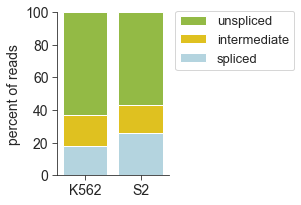

In [10]:
fig, ax = plt.subplots(figsize=(2,3))

# Plot the total reads
sns.barplot(x="species", y="all_unspliced", data=all_splicing_percent_df,
            label="unspliced", color="yellowgreen")

# Plot the level of intermediate + unspliced reads
sns.barplot(x="species", y="intermediate", data=all_splicing_percent_df,
            label="intermediate", color="gold")

# Plot the level of unspliced reads
sns.barplot(x="species", y="all_spliced", data=all_splicing_percent_df,
            label="spliced", color="lightblue")

plt.xlabel("")
plt.ylabel('percent of reads',fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.ylim(0,100)

plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
sns.despine(top=True, right=True)

plt.legend(bbox_to_anchor=(1.00, 1.05), fontsize=13)

plt.savefig('/path/to/Supplemental_Figure_6A_K562_S2_splicing_counts_barchart.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [119]:
# get the order of intron pairs in read junction dictionary
def get_splicing_order_df(intron_pairs_df):
    
    splicing_order = []

    pos_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])
    pos_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])

    neg_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])
    neg_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])

    all_yes = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="YES")])
    all_no = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="NO")])
    
    all_1st = pos_1st + neg_1st
    all_2nd = pos_2nd + neg_2nd
    percent_1st = float(all_1st) / float(all_1st + all_2nd) * 100.0

    splicing_order.append([all_yes,all_1st,all_2nd,all_no,percent_1st])

    splicing_order_df = pd.DataFrame(splicing_order)
    splicing_order_df.columns = ['yes_yes','yes_no','no_yes','no_no','percent_first']

    return splicing_order_df


def get_both_splicing_order_df(intron_pairs_df):
    
    splicing_order = []

    pos_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])
    pos_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])

    neg_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])
    neg_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])

    all_yes = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="YES")])
    all_no = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="NO")])
    
    all_1st = pos_1st + neg_1st
    all_2nd = pos_2nd + neg_2nd
    percent_1st = float(all_1st) / float(all_1st + all_2nd) * 100.0
    percent_2nd = float(all_2nd) / float(all_1st + all_2nd) * 100.0

    splicing_order.append(['first_spliced',percent_1st])
    splicing_order.append(['second_spliced',percent_2nd])

    splicing_order_df = pd.DataFrame(splicing_order)
    splicing_order_df.columns = ['order','splicing_status']

    return splicing_order_df

In [120]:
# FIGURE S6B - global splicing order from intron pairs for BL1184

# upload files from directory
BL1184_1_intron_pairs_df = pd.read_table("/path/to/BL1184_1_hg38_intron_pairs_df.txt",header=0)
BL1184_2_intron_pairs_df = pd.read_table("/path/to/BL1184_2_hg38_intron_pairs_df.txt",header=0)

# get splicing order dataframe for K56 cells
BL1184_1_splicing_order_df = get_splicing_order_df(BL1184_1_intron_pairs_df)
BL1184_2_splicing_order_df = get_splicing_order_df(BL1184_2_intron_pairs_df)

BL1184_splicing_order_df = pd.concat([BL1184_1_splicing_order_df,BL1184_2_splicing_order_df]).reset_index(drop=True)
BL1184_splicing_order_df['name'] = ['Human','Human']


In [121]:
BL1184_splicing_order_df


,yes_yes,yes_no,no_yes,no_no,percent_first,name
0,1744,833,936,15821,47.088751,Human
1,1929,558,646,9028,46.345515,Human


In [123]:
np.sum(BL1184_splicing_order_df['yes_no'])+np.sum(BL1184_splicing_order_df['no_yes'])

2973

In [179]:
BL1184_1_splicing_order_df = get_both_splicing_order_df(BL1184_1_intron_pairs_df)
BL1184_2_splicing_order_df = get_both_splicing_order_df(BL1184_2_intron_pairs_df)

BL1184_1_splicing_order_df['rep']=1
BL1184_2_splicing_order_df['rep']=2

BL1184_splicing_order_df = pd.concat([BL1184_1_splicing_order_df,BL1184_2_splicing_order_df]).reset_index(drop=True)
BL1184_splicing_order_df['name'] = 'Human'



In [183]:
BL1184_splicing_order_df

,order,splicing_status,rep,name
0,first_spliced,47.088751,1,Human
2,first_spliced,46.345515,2,Human


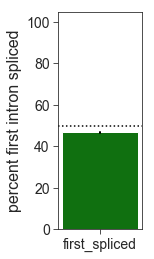

In [214]:
fig, ax = plt.subplots(figsize=(1.5,4))

splicing_order = BL1184_splicing_order_df[BL1184_splicing_order_df['order']=='first_spliced']

sns.barplot(x='order',y='splicing_status', palette=['green'], data=splicing_order,
            ci=None, errwidth=2, capsize=0.05)

# add a range bar for the two replicates
plt.plot([0,0], [splicing_order.iloc[0]['splicing_status'],splicing_order.iloc[1]['splicing_status']], '-', color='black', linewidth=2)

# add a vertical line at 50 to represent random
plt.axhline(y=50, color='black', linestyle=":")

plt.ylabel("percent first intron spliced", fontsize=16)
plt.xlabel("", fontsize=16)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
plt.legend(fontsize=14)

plt.ylim(0,105)

plt.savefig('/path/to/Supplemental_Figure_6B_BL1184_splicing_order_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
#SUPPLEMENTAL FIGURE 6C

In [31]:
def get_intron_pairs_df(read_junctions):
    intron_pairs = []

    # loop through all reads in the dictionary
    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_pairs = set()
        uniq_splice_pattern = set()
        
        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # only go through genes that have 2 or more introns
            if (len(read_junctions[read][gene]) > 1 ):

                # characterize the number of spliced and unspliced introns in the read
                splice_status = [row[6] for row in read_junctions[read][gene]]
                splice_status_join = '_'.join(splice_status)
                status_count = Counter(splice_status)
                 
                # only process the file if intron pattern hasn't been seen previously
                # for a gene that this read aligns to
                if (splice_status_join not in uniq_splice_pattern):
                    uniq_splice_pattern.add(splice_status_join)

                    spliced_count = status_count['YES']
                    unspliced_count = status_count['NO']

                    # build a dataframe of introns in the gene that map to this read
                    # and are capable of being sequenced if the read has no splicing
                    read_introns_df = pd.DataFrame(read_junctions[read][gene])
                    read_introns_df.columns = ['chrom','start','end','intron_count','strand','read_overlap','splice_status']
                    read_introns_df = read_introns_df[read_introns_df['read_overlap'] > 0].sort_values('intron_count').reset_index(drop=True)

                    # loop through introns that read maps to and find pairs
                    prev_intron_count = -2    # counter for the start becuase no intron should have a negative count

                    for i in range(len(read_introns_df)):
                        intron_count = read_introns_df.iloc[i]['intron_count']
                        intron_chrom = str(read_introns_df.iloc[i]['chrom'])
                        intron_start = str(read_introns_df.iloc[i]['start'])
                        intron_end = str(read_introns_df.iloc[i]['end'])
                        intron_strand = read_introns_df.iloc[i]['strand']
                        intron_splice = read_introns_df.iloc[i]['splice_status']
                        intron_coord = intron_chrom+'_'+intron_start+'_'+intron_end

                        # if intron counts are sequential (one follows the next)
                        # it is a true intron pair (i.e. neighboring introns)
                        if (intron_count - prev_intron_count == 1):
                            intron_pair_coord = prev_intron_coord+'_'+intron_coord

                            # record information about the read pair only if the coordinates of this
                            # intron pair have not yet been seen
                            if (intron_pair_coord not in uniq_pairs): 
                                uniq_pairs.add(intron_pair_coord)
                                prev_intron_start = prev_intron_coord.split('_')[1]
                                prev_intron_end = prev_intron_coord.split('_')[2]

                                # append intron pair coordinate and splicing information to a list
                                intron_pairs.append([read,gene,intron_chrom,prev_intron_start,prev_intron_end, prev_intron_count, 
                                                     int(intron_start),int(intron_end),int(intron_count), intron_strand,
                                                     prev_intron_splice, intron_splice])

                        # save information about this intron for the next pair
                        prev_intron_count = intron_count
                        prev_intron_coord = intron_coord
                        prev_intron_splice = intron_splice

    intron_pairs_df = pd.DataFrame(intron_pairs)
    intron_pairs_df.columns = ['read','gene','chrom','int1_start','int1_end','int1_count','int2_start','int2_end','int2_count','strand','int1_splice','int2_splice']        

    return intron_pairs_df


def get_intron_position_dictionaries(intron_info):
    
    first_intron_info = intron_info[intron_info['intron_order']=='first']
    first_intron_info = first_intron_info[['gene','count']]
    first_intron_info = first_intron_info.set_index('gene')['count'].to_dict()

    last_intron_info = intron_info[intron_info['intron_order']=='last']
    last_intron_info = last_intron_info[['gene','count']]
    last_intron_info = last_intron_info.set_index('gene')['count'].to_dict()

    return first_intron_info, last_intron_info



def get_first_middle_last_intron_pairs_df(intron_pairs_df, first_introns, last_introns):

    first_intron_pairs = []
    middle_intron_pairs = []
    last_intron_pairs = []

    for i in range(len(intron_pairs_df)):

        gene = intron_pairs_df.iloc[i]['gene']
        int1_count = intron_pairs_df.iloc[i]['int1_count']
        int2_count = intron_pairs_df.iloc[i]['int2_count'] 

        if ((first_introns[gene]==int1_count) or (first_introns[gene]==int2_count)):
            first_intron_pairs.append(intron_pairs_df.iloc[i].tolist())

        if ((first_introns[gene]!=int1_count) and (first_introns[gene]!=int2_count)
           and (last_introns[gene]!=int1_count) and (last_introns[gene]!=int2_count)):
            middle_intron_pairs.append(intron_pairs_df.iloc[i].tolist())

        if ((last_introns[gene]==int1_count) or (last_introns[gene]==int2_count)):
            last_intron_pairs.append(intron_pairs_df.iloc[i].tolist())

    first_intron_pairs_df = pd.DataFrame(first_intron_pairs)
    first_intron_pairs_df.columns = ['read','gene','chrom','int1_start','int1_end','int1_count','int2_start','int2_end','int2_count','strand','int1_splice','int2_splice']        

    middle_intron_pairs_df = pd.DataFrame(middle_intron_pairs)
    middle_intron_pairs_df.columns = ['read','gene','chrom','int1_start','int1_end','int1_count','int2_start','int2_end','int2_count','strand','int1_splice','int2_splice']        

    last_intron_pairs_df = pd.DataFrame(last_intron_pairs)
    last_intron_pairs_df.columns = ['read','gene','chrom','int1_start','int1_end','int1_count','int2_start','int2_end','int2_count','strand','int1_splice','int2_splice']        

    return first_intron_pairs_df, middle_intron_pairs_df, last_intron_pairs_df



# get the order of intron pairs in read junction dictionary
def get_splicing_order(intron_pairs_df, label):
    
    splicing_order = []

    pos_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])
    pos_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])

    neg_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])
    neg_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])

    all_yes = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="YES")])
    all_no = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="NO")])
    
    all_1st = pos_1st + neg_1st
    all_2nd = pos_2nd + neg_2nd
    percent_1st = float(all_1st) / float(all_1st + all_2nd) * 100.0

    splicing_order = [label,all_yes,all_1st,all_2nd,all_no,percent_1st]
    
    return splicing_order



# get a dataframe of splicing order to use for plotting
def get_splicing_order_df(first_intron_pairs_df, middle_intron_pairs_df, last_intron_pairs_df, sample):

    splicing_order = []
    
    splicing_order.append(get_splicing_order(first_intron_pairs_df, 'first'))
    splicing_order.append(get_splicing_order(middle_intron_pairs_df, 'middle'))
    splicing_order.append(get_splicing_order(last_intron_pairs_df, 'last'))
    
    splicing_order_df = pd.DataFrame(splicing_order)
    splicing_order_df.columns = ['position','yes_yes','yes_no','no_yes','no_no','percent_first']
    splicing_order_df['sample'] = sample
    
    return splicing_order_df

# function to label missing gene names with transcript names
def name_missing_genes(row):
    if pd.isnull(row['gene']):
        return (row['transcript'])

    else:
        return (row['gene'])


In [54]:
# get intron pairs with intron count details
K562_1_intron_pairs_df = get_intron_pairs_df(K562_1_splice_dictionary)
K562_2_intron_pairs_df = get_intron_pairs_df(K562_2_splice_dictionary)
K562_3_intron_pairs_df = get_intron_pairs_df(K562_3_splice_dictionary)
K562_4_intron_pairs_df = get_intron_pairs_df(K562_4_splice_dictionary)
K562_5a_intron_pairs_df = get_intron_pairs_df(K562_5a_splice_dictionary)
K562_5b_intron_pairs_df = get_intron_pairs_df(K562_5b_splice_dictionary)

K562_5_intron_pairs_df = pd.concat([K562_5a_intron_pairs_df,K562_5b_intron_pairs_df], axis = 0)

S2_1a_intron_pairs_df = get_intron_pairs_df(S2_1a_splice_dictionary)
S2_1b_intron_pairs_df = get_intron_pairs_df(S2_1b_splice_dictionary)
S2_2_intron_pairs_df = get_intron_pairs_df(S2_2_splice_dictionary)
S2_3_intron_pairs_df = get_intron_pairs_df(S2_3_splice_dictionary)

S2_1_intron_pairs_df = pd.concat([S2_1a_intron_pairs_df,S2_1b_intron_pairs_df], axis = 0)


In [55]:
# get first and last intron dictionaries

# upload file with information about all introns in dmel6
hg38_intron_info = pd.read_table('/path/to/annotation_files/hg38_all_intron_features.txt')
dm6_intron_info = pd.read_table('/path/to/annotation_files/dmel6_all_intron_features.txt')

hg38_first_introns, hg38_last_introns = get_intron_position_dictionaries(hg38_intron_info)
dm6_first_introns, dm6_last_introns = get_intron_position_dictionaries(dm6_intron_info)


In [56]:
# get first, middle, and last splicing pairs dataframes for all smpales

K562_1_first_intron_pairs_df, K562_1_middle_intron_pairs_df, K562_1_last_intron_pairs_df = get_first_middle_last_intron_pairs_df(K562_1_intron_pairs_df, hg38_first_introns, hg38_last_introns)
K562_2_first_intron_pairs_df, K562_2_middle_intron_pairs_df, K562_2_last_intron_pairs_df = get_first_middle_last_intron_pairs_df(K562_2_intron_pairs_df, hg38_first_introns, hg38_last_introns)
K562_3_first_intron_pairs_df, K562_3_middle_intron_pairs_df, K562_3_last_intron_pairs_df = get_first_middle_last_intron_pairs_df(K562_3_intron_pairs_df, hg38_first_introns, hg38_last_introns)
K562_4_first_intron_pairs_df, K562_4_middle_intron_pairs_df, K562_4_last_intron_pairs_df = get_first_middle_last_intron_pairs_df(K562_4_intron_pairs_df, hg38_first_introns, hg38_last_introns)
K562_5_first_intron_pairs_df, K562_5_middle_intron_pairs_df, K562_5_last_intron_pairs_df = get_first_middle_last_intron_pairs_df(K562_5_intron_pairs_df, hg38_first_introns, hg38_last_introns)

S2_1_first_intron_pairs_df, S2_1_middle_intron_pairs_df, S2_1_last_intron_pairs_df = get_first_middle_last_intron_pairs_df(S2_1_intron_pairs_df, dm6_first_introns, dm6_last_introns)
S2_2_first_intron_pairs_df, S2_2_middle_intron_pairs_df, S2_2_last_intron_pairs_df = get_first_middle_last_intron_pairs_df(S2_2_intron_pairs_df, dm6_first_introns, dm6_last_introns)
S2_3_first_intron_pairs_df, S2_3_middle_intron_pairs_df, S2_3_last_intron_pairs_df = get_first_middle_last_intron_pairs_df(S2_3_intron_pairs_df, dm6_first_introns, dm6_last_introns)


In [57]:
# get first, middle, and last splicing pairs dataframes for all smpales

K562_1_splicing_order_df = get_splicing_order_df(K562_1_first_intron_pairs_df, K562_1_middle_intron_pairs_df, K562_1_last_intron_pairs_df, 'Human')
K562_2_splicing_order_df = get_splicing_order_df(K562_2_first_intron_pairs_df, K562_2_middle_intron_pairs_df, K562_2_last_intron_pairs_df, 'Human')
K562_3_splicing_order_df = get_splicing_order_df(K562_3_first_intron_pairs_df, K562_3_middle_intron_pairs_df, K562_3_last_intron_pairs_df, 'Human')
K562_4_splicing_order_df = get_splicing_order_df(K562_4_first_intron_pairs_df, K562_4_middle_intron_pairs_df, K562_4_last_intron_pairs_df, 'Human')
K562_5_splicing_order_df = get_splicing_order_df(K562_5_first_intron_pairs_df, K562_5_middle_intron_pairs_df, K562_5_last_intron_pairs_df, 'Human')

S2_1_splicing_order_df = get_splicing_order_df(S2_1_first_intron_pairs_df, S2_1_middle_intron_pairs_df, S2_1_last_intron_pairs_df, 'Drosophila')
S2_2_splicing_order_df = get_splicing_order_df(S2_2_first_intron_pairs_df, S2_2_middle_intron_pairs_df, S2_2_last_intron_pairs_df, 'Drosophila')
S2_3_splicing_order_df = get_splicing_order_df(S2_3_first_intron_pairs_df, S2_3_middle_intron_pairs_df, S2_3_last_intron_pairs_df, 'Drosophila')


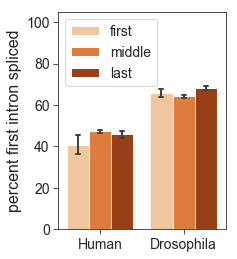

In [58]:
# Plot for Supp Fig 6C

K562_splicing_order_df = pd.concat([K562_1_splicing_order_df,K562_2_splicing_order_df,K562_3_splicing_order_df,K562_4_splicing_order_df,K562_5_splicing_order_df]).reset_index(drop=True)
S2_splicing_order_df = pd.concat([S2_1_splicing_order_df,S2_2_splicing_order_df,S2_3_splicing_order_df]).reset_index(drop=True)

all_splicing_order_df = pd.concat([K562_splicing_order_df, S2_splicing_order_df])
                                   
fig, ax = plt.subplots(figsize=(3,4))

fill_colors = [sns.color_palette("Oranges")[1],sns.color_palette("Oranges")[3],sns.color_palette("Oranges")[5]]
sns.barplot(x='sample',y='percent_first', hue='position', palette=fill_colors, data=all_splicing_order_df,
            ci=68, errwidth=2, capsize=0.05)

plt.ylabel("percent first intron spliced", fontsize=16)
plt.xlabel("", fontsize=16)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
plt.legend(fontsize=14)

plt.ylim(0,105)

plt.savefig('/path/to/Supplemental_Figure_6C_K562_S2_order_of_splicing_byPosition_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
# SUPPLEMENTAL FIGURE 6D

In [59]:

# make a dataframe with the number of introns for every gene in the intron file
def get_intron_length(intron_df):

    # get length of all introns
    length = intron_df['intron_end']-intron_df['intron_start']
    intron_length_df = pd.concat([intron_df['name'],length],axis=1)
    intron_length_df.columns = ['name','intron_length']
    
    return intron_length_df

     

# make a dataframe with the transcript RPKM information for all introns
def get_RPKM_df(intron_df, featureCount_df):

    merge_df = pd.merge(intron_df,featureCount_df, how='left', on='gene')
    
    new_RPKM_df = pd.concat([merge_df['name'],merge_df['exon_RPKM']], axis=1)
    new_RPKM_df.columns = ['name','transcript_RPKM']
    
    return new_RPKM_df


# get the order of intron pairs in read junction dictionary
def get_both_splicing_order_df(intron_pairs_df):
    
    splicing_order = []

    pos_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])
    pos_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])

    neg_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])
    neg_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])

    all_yes = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="YES")])
    all_no = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="NO")])
    
    all_1st = pos_1st + neg_1st
    all_2nd = pos_2nd + neg_2nd
    percent_1st = float(all_1st) / float(all_1st + all_2nd) * 100.0
    percent_2nd = float(all_2nd) / float(all_1st + all_2nd) * 100.0

    splicing_order.append(['first_spliced',percent_1st])
    splicing_order.append(['second_spliced',percent_2nd])

    splicing_order_df = pd.DataFrame(splicing_order)
    splicing_order_df.columns = ['order','splicing_status']

    return splicing_order_df


# get the order of intron pairs in read junction dictionary
def get_intron_pairs_RPKM_range(intron_pairs_df, low, high):
    
    intron_pairs_low_df = intron_pairs_df[intron_pairs_df['transcript_RPKM']<=low]
    intron_pairs_low = get_both_splicing_order_df(intron_pairs_low_df)
    intron_pairs_low['RPKM'] = 'low'
    
    intron_pairs_med_df = intron_pairs_df[(intron_pairs_df['transcript_RPKM']>low) & (intron_pairs_df['transcript_RPKM']<high)]
    intron_pairs_med = get_both_splicing_order_df(intron_pairs_med_df)
    intron_pairs_med['RPKM'] = 'med'

    intron_pairs_high_df =  intron_pairs_df[intron_pairs_df['transcript_RPKM']>=high]
    intron_pairs_high = get_both_splicing_order_df(intron_pairs_high_df)
    intron_pairs_high['RPKM'] = 'high'

    return intron_pairs_low, intron_pairs_med, intron_pairs_high


In [60]:
# read in intron coordinate bed file
hg38_intron_df = pd.read_table('/path/to/annotation_files/NCBI_RefSeq_hg38_introns_parsed.bed',header=None, low_memory=False)
hg38_intron_df.columns = ['chrom','intron_start','intron_end','name','zero','strand']

# convert name to include both gene name and intron number
hg38_intron_df['name'] = hg38_intron_df['name'].apply(lambda x: '_'.join(x.split('_')[0:4]))

# modify and add columns for easier analysis
hg38_intron_df['chrom'] = hg38_intron_df['chrom'].apply(lambda x: 'chr'+str(x))
hg38_intron_df['gene'] = hg38_intron_df['name'].apply(lambda x: '_'.join(x.split('_')[0:2]))
hg38_intron_df['feature'] = hg38_intron_df['name'].apply(lambda x: x.split('_')[2])
hg38_intron_df['count'] = hg38_intron_df['name'].apply(lambda x: x.split('_')[3]).astype(int)
hg38_intron_df = hg38_intron_df.drop_duplicates(subset=['name']).reset_index(drop=True)


In [62]:
# get intron length
hg38_intron_lengths = get_intron_length(hg38_intron_df)

# read in PSI_counts bed file from Illumina total RNA-seq
hg38_tot1_featureCounts_df = pd.read_table('/path/to/tot_1_featureCount.txt')

# get PSI scores for each dataset
hg38_tot1_RPKM_df = get_RPKM_df(hg38_intron_df, hg38_tot1_featureCounts_df)

# merge PSI scores from each condition
hg38_totRPKM_values = pd.concat([hg38_tot1_RPKM_df['name'],hg38_tot1_RPKM_df['transcript_RPKM']], axis=1)
hg38_totRPKM_values.columns = ['name','tot_RPKM']

# merge datasets to make a large dataset with all intron information
hg38_merge_df = pd.merge(hg38_intron_df, hg38_totRPKM_values, how='left', on='name')

hg38_merge_df = hg38_merge_df.drop_duplicates(subset=['chrom','intron_start','intron_end','strand'])


In [63]:
# read in intron coordinate bed file
dmel_intron_df = pd.read_table('/path/to/annotation_files/dm6_RefSeq_introns_parsed.bed',header=None)
dmel_intron_df.columns = ['chrom','intron_start','intron_end','name','zero','strand']

# convert name to include both gene name and intron number
dmel_intron_df['name'] = dmel_intron_df['name'].apply(lambda x: '_'.join(x.split('_')[0:4]))

# modify and add columns for easier analysis
dmel_intron_df['chrom'] = dmel_intron_df['chrom'].apply(lambda x: 'chr'+str(x))
dmel_intron_df['gene'] = dmel_intron_df['name'].apply(lambda x: '_'.join(x.split('_')[0:2]))
dmel_intron_df['feature'] = dmel_intron_df['name'].apply(lambda x: x.split('_')[2])
dmel_intron_df['count'] = dmel_intron_df['name'].apply(lambda x: x.split('_')[3]).astype(int)
dmel_intron_df = dmel_intron_df.drop_duplicates(subset=['name']).reset_index(drop=True)


In [64]:
# get intron length
dmel_intron_lengths = get_intron_length(dmel_intron_df)

# read in featureCounts bed file
dmel_tot_featureCounts_df = pd.read_table('/path/to/DmelS2_total_RNAseq_featureCount.txt')

dmel_tot_RPKM_df = get_RPKM_df(dmel_intron_df, dmel_tot_featureCounts_df)

### IMPORTANT NOTE: total RNA-seq dataset is not stranded, but analysis was performed assuming that it was

# merge datasets to make a large dataset with all intron information
dm6_merge_df = pd.merge(dmel_intron_df, dmel_tot_RPKM_df, how='left', on='name')

dm6_merge_df = dm6_merge_df.drop_duplicates(subset=['chrom','intron_start','intron_end','strand'])


In [65]:
# upload files from directory
K562_1_intron_pairs_df = pd.read_table("/path/to/K562_1_hg38_intron_pairs_df.txt",header=0)
K562_2_intron_pairs_df = pd.read_table("/path/to/K562_2_hg38_intron_pairs_df.txt",header=0)
K562_3_intron_pairs_df = pd.read_table("/path/to/K562_3_hg38_intron_pairs_df.txt",header=0)
K562_4_intron_pairs_df = pd.read_table("/path/to/K562_4_hg38_intron_pairs_df.txt",header=0)
K562_5a_intron_pairs_df = pd.read_table("/path/to/K562_5a_hg38_intron_pairs_df.txt",header=0)
K562_5b_intron_pairs_df = pd.read_table("/path/to/K562_5b_hg38_intron_pairs_df.txt",header=0)
K562_5_intron_pairs_df = pd.concat([K562_5a_intron_pairs_df,K562_5b_intron_pairs_df],axis=0)

K562_1_intron_pairs_df.columns = ['read','chrom','intron_start','intron_end','int2_start','int2_end','strand','int1_splice','int2_splice']
K562_2_intron_pairs_df.columns = ['read','chrom','intron_start','intron_end','int2_start','int2_end','strand','int1_splice','int2_splice']
K562_3_intron_pairs_df.columns = ['read','chrom','intron_start','intron_end','int2_start','int2_end','strand','int1_splice','int2_splice']
K562_4_intron_pairs_df.columns = ['read','chrom','intron_start','intron_end','int2_start','int2_end','strand','int1_splice','int2_splice']
K562_5_intron_pairs_df.columns = ['read','chrom','intron_start','intron_end','int2_start','int2_end','strand','int1_splice','int2_splice']

K562_1_intron_pairs_df['chrom']='chr'+K562_1_intron_pairs_df['chrom']
K562_2_intron_pairs_df['chrom']='chr'+K562_2_intron_pairs_df['chrom']
K562_3_intron_pairs_df['chrom']='chr'+K562_3_intron_pairs_df['chrom']
K562_4_intron_pairs_df['chrom']='chr'+K562_4_intron_pairs_df['chrom']
K562_5_intron_pairs_df['chrom']='chr'+K562_5_intron_pairs_df['chrom']

K562_1_intron_pairs_merge_df = pd.merge(K562_1_intron_pairs_df,hg38_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)
K562_2_intron_pairs_merge_df = pd.merge(K562_2_intron_pairs_df,hg38_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)
K562_3_intron_pairs_merge_df = pd.merge(K562_3_intron_pairs_df,hg38_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)
K562_4_intron_pairs_merge_df = pd.merge(K562_4_intron_pairs_df,hg38_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)
K562_5_intron_pairs_merge_df = pd.merge(K562_5_intron_pairs_df,hg38_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)

K562_1_intron_pairs_merge_df.columns = ['read','chrom','int1_start','int1_end','int2_start','int2_end','strand','int1_splice','int2_splice','name','zero','gene','feature','count','transcript_RPKM']
K562_2_intron_pairs_merge_df.columns = ['read','chrom','int1_start','int1_end','int2_start','int2_end','strand','int1_splice','int2_splice','name','zero','gene','feature','count','transcript_RPKM']
K562_3_intron_pairs_merge_df.columns = ['read','chrom','int1_start','int1_end','int2_start','int2_end','strand','int1_splice','int2_splice','name','zero','gene','feature','count','transcript_RPKM']
K562_4_intron_pairs_merge_df.columns = ['read','chrom','int1_start','int1_end','int2_start','int2_end','strand','int1_splice','int2_splice','name','zero','gene','feature','count','transcript_RPKM']
K562_5_intron_pairs_merge_df.columns = ['read','chrom','int1_start','int1_end','int2_start','int2_end','strand','int1_splice','int2_splice','name','zero','gene','feature','count','transcript_RPKM']


# get splicing order dataframe for K562 splicing order dataset
low=2
high=10

K562_1_intron_pairs_low, K562_1_intron_pairs_med, K562_1_intron_pairs_high = get_intron_pairs_RPKM_range(K562_1_intron_pairs_merge_df, low, high)
K562_2_intron_pairs_low, K562_2_intron_pairs_med, K562_2_intron_pairs_high = get_intron_pairs_RPKM_range(K562_2_intron_pairs_merge_df, low, high)
K562_3_intron_pairs_low, K562_3_intron_pairs_med, K562_3_intron_pairs_high = get_intron_pairs_RPKM_range(K562_3_intron_pairs_merge_df, low, high)
K562_4_intron_pairs_low, K562_4_intron_pairs_med, K562_4_intron_pairs_high = get_intron_pairs_RPKM_range(K562_4_intron_pairs_merge_df, low, high)
K562_5_intron_pairs_low, K562_5_intron_pairs_med, K562_5_intron_pairs_high = get_intron_pairs_RPKM_range(K562_5_intron_pairs_merge_df, low, high)

K562_intron_pairs_low = pd.concat([K562_1_intron_pairs_low,K562_2_intron_pairs_low,K562_3_intron_pairs_low,K562_4_intron_pairs_low,K562_5_intron_pairs_low])
K562_intron_pairs_med = pd.concat([K562_1_intron_pairs_med,K562_2_intron_pairs_med,K562_3_intron_pairs_med,K562_4_intron_pairs_med,K562_5_intron_pairs_med])
K562_intron_pairs_high = pd.concat([K562_1_intron_pairs_high,K562_2_intron_pairs_high,K562_3_intron_pairs_high,K562_4_intron_pairs_high,K562_5_intron_pairs_high])

K562_splicing_order_df = pd.concat([K562_intron_pairs_low,K562_intron_pairs_med,K562_intron_pairs_high])
K562_splicing_order_df = K562_splicing_order_df[K562_splicing_order_df['order']=='first_spliced']
K562_splicing_order_df['species']='Human'


In [66]:
# upload files from directory
S2_1_intron_pairs_df = pd.read_table("/path/to/S2_1_dm6_intron_pairs_df.txt",header=0)
S2_2_intron_pairs_df = pd.read_table("/path/to/S2_2_dm6_intron_pairs_df.txt",header=0)
S2_3_intron_pairs_df = pd.read_table("/path/to/S2_3_dm6_intron_pairs_df.txt",header=0)

S2_1_intron_pairs_df.columns = ['read','chrom','intron_start','intron_end','int2_start','int2_end','strand','int1_splice','int2_splice']
S2_2_intron_pairs_df.columns = ['read','chrom','intron_start','intron_end','int2_start','int2_end','strand','int1_splice','int2_splice']
S2_3_intron_pairs_df.columns = ['read','chrom','intron_start','intron_end','int2_start','int2_end','strand','int1_splice','int2_splice']

S2_1_intron_pairs_merge_df = pd.merge(S2_1_intron_pairs_df,dm6_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)
S2_2_intron_pairs_merge_df = pd.merge(S2_2_intron_pairs_df,dm6_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)
S2_3_intron_pairs_merge_df = pd.merge(S2_3_intron_pairs_df,dm6_merge_df,on=['chrom','intron_start','intron_end','strand']).reset_index(drop=True)

S2_1_intron_pairs_merge_df.columns = ['read','chrom','int1_start','int1_end','int2_start','int2_end','strand','int1_splice','int2_splice','name','zero','gene','feature','count','transcript_RPKM']
S2_2_intron_pairs_merge_df.columns = ['read','chrom','int1_start','int1_end','int2_start','int2_end','strand','int1_splice','int2_splice','name','zero','gene','feature','count','transcript_RPKM']
S2_3_intron_pairs_merge_df.columns = ['read','chrom','int1_start','int1_end','int2_start','int2_end','strand','int1_splice','int2_splice','name','zero','gene','feature','count','transcript_RPKM']

# get splicing order dataframe for K562 splicing order dataset
low=10
high=50

S2_1_intron_pairs_low, S2_1_intron_pairs_med, S2_1_intron_pairs_high = get_intron_pairs_RPKM_range(S2_1_intron_pairs_merge_df, low, high)
S2_2_intron_pairs_low, S2_2_intron_pairs_med, S2_2_intron_pairs_high = get_intron_pairs_RPKM_range(S2_2_intron_pairs_merge_df, low, high)
S2_3_intron_pairs_low, S2_3_intron_pairs_med, S2_3_intron_pairs_high = get_intron_pairs_RPKM_range(S2_3_intron_pairs_merge_df, low, high)

S2_intron_pairs_low = pd.concat([S2_1_intron_pairs_low,S2_2_intron_pairs_low,S2_3_intron_pairs_low])
S2_intron_pairs_med = pd.concat([S2_1_intron_pairs_med,S2_2_intron_pairs_med,S2_3_intron_pairs_med])
S2_intron_pairs_high = pd.concat([S2_1_intron_pairs_high,S2_2_intron_pairs_high,S2_3_intron_pairs_high])

S2_splicing_order_df = pd.concat([S2_intron_pairs_low,S2_intron_pairs_med,S2_intron_pairs_high])
S2_splicing_order_df = S2_splicing_order_df[S2_splicing_order_df['order']=='first_spliced']
S2_splicing_order_df['species']='Drosophila'


In [67]:
all_splicing_order_df = pd.concat([K562_splicing_order_df,S2_splicing_order_df]).reset_index(drop=True)
all_splicing_order_df = all_splicing_order_df[all_splicing_order_df['order']=='first_spliced']
all_splicing_order_df

,order,splicing_status,RPKM,species
0,first_spliced,42.857143,low,Human
1,first_spliced,50.000000,low,Human
2,first_spliced,45.945946,low,Human
3,first_spliced,49.152542,low,Human
4,first_spliced,38.181818,low,Human
5,first_spliced,46.632124,med,Human
6,first_spliced,56.818182,med,Human
7,first_spliced,44.256757,med,Human
8,first_spliced,47.956989,med,Human
9,first_spliced,45.391304,med,Human


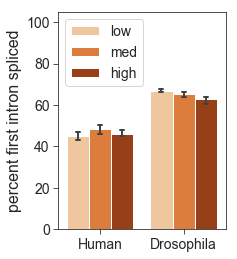

In [68]:
# Plot for Supp Figure 6D
                                   
fig, ax = plt.subplots(figsize=(3,4))

fill_colors = [sns.color_palette("Oranges")[1],sns.color_palette("Oranges")[3],sns.color_palette("Oranges")[5]]
sns.barplot(x='species',y='splicing_status', hue='RPKM', palette=fill_colors, data=all_splicing_order_df,
            ci=68, errwidth=2, capsize=0.05)

plt.ylabel("percent first intron spliced", fontsize=16)
plt.xlabel("", fontsize=16)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
plt.legend(loc=2, fontsize=14)

plt.ylim(0,105)

plt.savefig('/path/to/Supplemental_Figure_6D_K562_S2_order_of_splicing_byRPKM_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
### Supplemental Figures S6F-G

In [38]:
# upload file with information about all introns in hg38 or dmel6
hg38_intron_info = pd.read_table('/path/to/annotation_files/hg38_all_intron_features.txt')
hg38_intron_info = hg38_intron_info[['chrom','start','end','name','intron_length','strand']]
hg38_intron_info = hg38_intron_info.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

dm6_intron_info = pd.read_table('/path/to/annotation_files/dmel6_all_intron_features.txt')
dm6_intron_info = dm6_intron_info[['chrom','start','end','name','intron_length','strand']]
dm6_intron_info = dm6_intron_info.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)


In [14]:
# upload read pair dataframes from directory (for hg38)
K562_1_intron_pairs_df = pd.read_table("/path/to/K562_1_hg38_intron_pairs_df.txt",header=0)
K562_2_intron_pairs_df = pd.read_table("/path/to/K562_2_hg38_intron_pairs_df.txt",header=0)
K562_3_intron_pairs_df = pd.read_table("/path/to/K562_3_hg38_intron_pairs_df.txt",header=0)
K562_4_intron_pairs_df = pd.read_table("/path/to/K562_4_hg38_intron_pairs_df.txt",header=0)
K562_5a_intron_pairs_df = pd.read_table("/path/to/K562_5a_hg38_intron_pairs_df.txt",header=0)
K562_5b_intron_pairs_df = pd.read_table("/path/to/K562_5b_hg38_intron_pairs_df.txt",header=0)

K562_intron_pairs_df = pd.concat([K562_1_intron_pairs_df, K562_2_intron_pairs_df, K562_3_intron_pairs_df, K562_4_intron_pairs_df, K562_5a_intron_pairs_df, K562_5b_intron_pairs_df])


# upload read pair dataframes from directory (for dm6)
S2_1_intron_pairs_df = pd.read_table("/path/to/S2_1_dm6_intron_pairs_df.txt",header=0)
S2_2_intron_pairs_df = pd.read_table("/path/to/S2_2_dm6_intron_pairs_df.txt",header=0)
S2_3_intron_pairs_df = pd.read_table("/path/to/S2_3_dm6_intron_pairs_df.txt",header=0)

S2_intron_pairs_df = pd.concat([S2_1_intron_pairs_df, S2_2_intron_pairs_df, S2_3_intron_pairs_df])


In [24]:
# get intron lengths within pairs (human)
K562_intron_pairs_df['int1_length'] = K562_intron_pairs_df['int1_end'] - K562_intron_pairs_df['int1_start']
K562_intron_pairs_df['int2_length'] = K562_intron_pairs_df['int2_end'] - K562_intron_pairs_df['int2_start']

# get intron lengths within pairs (Drosophila)
S2_intron_pairs_df['int1_length'] = S2_intron_pairs_df['int1_end'] - S2_intron_pairs_df['int1_start']
S2_intron_pairs_df['int2_length'] = S2_intron_pairs_df['int2_end'] - S2_intron_pairs_df['int2_start']


In [25]:
# get first and last introns from pairs (human)
K562_pos_intron1 = K562_intron_pairs_df[K562_intron_pairs_df['strand']=='+']['int1_length'].reset_index(drop=True)
K562_pos_intron2 = K562_intron_pairs_df[K562_intron_pairs_df['strand']=='+']['int2_length'].reset_index(drop=True)

K562_neg_intron1 = K562_intron_pairs_df[K562_intron_pairs_df['strand']=='-']['int2_length'].reset_index(drop=True)
K562_neg_intron2 = K562_intron_pairs_df[K562_intron_pairs_df['strand']=='-']['int1_length'].reset_index(drop=True)

K562_intron1 = pd.concat([K562_neg_intron1, K562_pos_intron1]).reset_index(drop=True)
K562_intron2 = pd.concat([K562_neg_intron2, K562_pos_intron2]).reset_index(drop=True)

              
# get first and last introns from pairs (human)
S2_pos_intron1 = S2_intron_pairs_df[S2_intron_pairs_df['strand']=='+']['int1_length'].reset_index(drop=True)
S2_pos_intron2 = S2_intron_pairs_df[S2_intron_pairs_df['strand']=='+']['int2_length'].reset_index(drop=True)

S2_neg_intron1 = S2_intron_pairs_df[S2_intron_pairs_df['strand']=='-']['int2_length'].reset_index(drop=True)
S2_neg_intron2 = S2_intron_pairs_df[S2_intron_pairs_df['strand']=='-']['int1_length'].reset_index(drop=True)

S2_intron1 = pd.concat([S2_neg_intron1, S2_pos_intron1]).reset_index(drop=True)
S2_intron2 = pd.concat([S2_neg_intron2, S2_pos_intron2]).reset_index(drop=True)


In [26]:
# add min and max to match all introns (human)
K562_intron1 = K562_intron1.append(pd.DataFrame([np.min(hg38_intron_info['intron_length'])]))
K562_intron1 = K562_intron1.append(pd.DataFrame([np.max(hg38_intron_info['intron_length'])]))

K562_intron2 = K562_intron2.append(pd.DataFrame([np.min(hg38_intron_info['intron_length'])]))
K562_intron2 = K562_intron2.append(pd.DataFrame([np.max(hg38_intron_info['intron_length'])]))

# add min and max to match all introns (Drosophila)
S2_intron1 = S2_intron1.append(pd.DataFrame([np.min(dm6_intron_info['intron_length'])]))
S2_intron1 = S2_intron1.append(pd.DataFrame([np.max(dm6_intron_info['intron_length'])]))

S2_intron2 = S2_intron2.append(pd.DataFrame([np.min(dm6_intron_info['intron_length'])]))
S2_intron2 = S2_intron2.append(pd.DataFrame([np.max(dm6_intron_info['intron_length'])]))


In [32]:
# get reads per gene for ONT sequencing datasets
# upload gene information as a BedTool for parsing
genes_df = pd.read_table('/path/to/annotation_files/NCBI_RefSeq_hg38_genes_parsed.bed',header=None)
genes_df = genes_df.drop([6,7,8,9,10,11], axis=1) # drop irrelevant columns from dataframe
genes_df.columns = ['chrom','start','end','transcript','gene_length','strand']
genes_df['gene_length'] = genes_df['end']-genes_df['start']
genes_df['transcript'] = genes_df.apply(lambda row: row['transcript'].split('.')[0], axis=1)
genes_df = genes_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

# get list of gene names for all transcripts
names_df = pd.read_table('/path/to/annotation_files/hg38_UCSC_refGene_names.txt', header=None)
names_df.columns = ['gene','transcript']

genes_names_merge = pd.merge(genes_df, names_df, on=['transcript'], how='left')
genes_names_merge['gene'] = genes_names_merge.apply(lambda row: name_missing_genes(row) , axis=1)
genes_names_merge = genes_names_merge.sort_values(by='gene_length', ascending=False).reset_index(drop=True)
genes_names_merge = genes_names_merge.drop_duplicates(subset=['gene'], keep='first').reset_index(drop=True)

genes_names_merge = genes_names_merge.sort_values(by=['chrom','start','end'], ascending=True).reset_index(drop=True)

# create a bed file for all unique genes
gene_bed = BedTool.from_dataframe(genes_names_merge)


K562_bamFile = pybedtools.BedTool('/path/to/all_K562_hg38_minimap2_uniq_sort.bam')
K562_bedFile = K562_bamFile.bam_to_bed()

K562_coverage = gene_bed.coverage(K562_bedFile, s=True, counts=True) 
K562_df = K562_coverage.to_dataframe() # covert to dataframe
K562_df.columns =['chrom','start','end','transcript','score','strand','gene','count'] # label columns
K562_df = K562_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True) # remove duplicate gene coords


In [33]:
K562_genes = K562_df.copy()
#K562_genes = K562_df[K562_df['count']>100]['transcript'].reset_index(drop=True)

K562_genes['expression'] = K562_genes['count']/(K562_genes['end']-K562_genes['start'])
K562_genes = K562_genes[K562_genes['expression']>K562_genes['expression'].quantile(q=0.9)].reset_index(drop=True)

hg38_introns = hg38_intron_info.copy()
hg38_introns['gene'] = hg38_introns.apply(lambda row: str(row['name'].split("_")[0])+'_'+str(row['name'].split("_")[1].split(".")[0]) , axis=1)

K562_introns = hg38_introns[hg38_introns.apply(lambda row: row['gene'] in set(K562_genes['transcript']) , axis=1)].reset_index(drop=True)

In [34]:
len(K562_introns)


12420

/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


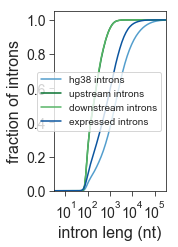

In [35]:
# Supplemental Figure 6F

fig, ax = plt.subplots(figsize=(2,3.3))

hg38_intron_lengths = np.log10(hg38_intron_info['intron_length'].values)
K562_intron1_lengths = np.log10(K562_intron1.values)
K562_intron2_lengths = np.log10(K562_intron2.values)
K562_introns_expr_lengths = np.log10(K562_introns['intron_length'].values)

ax = sns.distplot(hg38_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], bins=np.max(hg38_intron_info['intron_length']), label='hg38 introns')
sns.distplot(K562_intron1_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[5], bins=np.max(hg38_intron_info['intron_length']), label='upstream introns')
sns.distplot(K562_intron2_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[3], bins=np.max(hg38_intron_info['intron_length']), label='downstream introns')
sns.distplot(K562_introns_expr_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[5], bins=np.max(hg38_intron_info['intron_length']), label='expressed introns')

x_labels = ["$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$","$\mathregular{10^{5}}$"]
plt.xticks([1,2,3,4,5], x_labels, fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(0.5,5.5)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("fraction of introns", fontsize=16)
ax.set_xlabel("intron leng (nt)", fontsize=16)
#ax.legend(fontsize=14)

plt.savefig('/path/to/SupFigure_6/Supplemental_Figure_6F_K562_pairs_intron_length_cumdist_plot_withExpressedIntrons.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [35]:
# get reads per gene for ONT sequencing datasets
# upload gene information as a BedTool for parsing
genes_df = pd.read_table('/path/to/annotation_files/dm6_RefSeq_genes_parsed.bed',header=None)
genes_df.columns = ['chrom','start','end','transcript','gene_length','strand']
genes_df['chrom'] = "chr"+genes_df['chrom']
genes_df['gene_length'] = genes_df['end']-genes_df['start']
genes_df['transcript'] = genes_df.apply(lambda row: row['transcript'].split('.')[0], axis=1)
genes_df = genes_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

# get list of gene names for all transcripts
names_df = pd.read_table('/path/to/annotation_files/dm6_RefSeq_names_parsed.txt', header=None)
names_df.columns = ['gene','transcript']

genes_names_merge = pd.merge(genes_df, names_df, on=['transcript'], how='left')
genes_names_merge['gene'] = genes_names_merge.apply(lambda row: name_missing_genes(row) , axis=1)
genes_names_merge = genes_names_merge.sort_values(by='gene_length', ascending=False).reset_index(drop=True)
genes_names_merge = genes_names_merge.drop_duplicates(subset=['gene'], keep='first').reset_index(drop=True)

genes_names_merge = genes_names_merge.sort_values(by=['chrom','start','end'], ascending=True).reset_index(drop=True)

# create a bed file for all unique genes
gene_bed = BedTool.from_dataframe(genes_names_merge)



In [36]:
# get K562 ONT coverage information for both replicates
S2_bamFile = pybedtools.BedTool('/path/to/all_S2_dmel6_minimap2_uniq_sort.bam')

S2_bedFile = S2_bamFile.bam_to_bed()

# get number of reads that overlap each gene feature
S2_coverage = gene_bed.coverage(S2_bedFile, s=True, counts=True) 

# make a dataframe from coverage file
S2_df = S2_coverage.to_dataframe() # covert to dataframe
S2_df.columns =['chrom','start','end','transcript','score','strand','gene','count'] # label columns
S2_df = S2_df.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True) # remove duplicate gene coords


In [39]:
S2_genes = S2_df.copy()

S2_genes['expression'] = S2_genes['count']/(S2_genes['end']-S2_genes['start'])
S2_genes = S2_genes[S2_genes['expression']>S2_genes['expression'].quantile(q=0.9)].reset_index(drop=True)

dm6_introns = dm6_intron_info.copy()
dm6_introns['gene'] = dm6_introns.apply(lambda row: str(row['name'].split("_")[0])+'_'+str(row['name'].split("_")[1].split(".")[0]) , axis=1)

S2_introns = dm6_introns[dm6_introns.apply(lambda row: row['gene'] in set(S2_genes['transcript']) , axis=1)].reset_index(drop=True)

In [40]:
len(S2_introns)


3056

/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


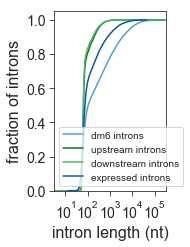

In [47]:
fig, ax = plt.subplots(figsize=(2,3.3))

dm6_intron_lengths = np.log10(dm6_intron_info['intron_length'].values)
S2_intron1_lengths = np.log10(S2_intron1.values)
S2_intron2_lengths = np.log10(S2_intron2.values)
S2_introns_expr_lengths = np.log10(S2_introns['intron_length'].values)

ax = sns.distplot(dm6_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], bins=np.max(dm6_intron_info['intron_length']), label='dm6 introns')
sns.distplot(S2_intron1_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[5], bins=np.max(dm6_intron_info['intron_length']), label='upstream introns')
sns.distplot(S2_intron2_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[3], bins=np.max(dm6_intron_info['intron_length']), label='downstream introns')
sns.distplot(S2_introns_expr_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[5], bins=np.max(hg38_intron_info['intron_length']), label='expressed introns')

x_labels = ["$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$","$\mathregular{10^{5}}$"]
plt.xticks([1,2,3,4,5], x_labels, fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(0.5,5.5)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("fraction of introns", fontsize=16)
ax.set_xlabel("intron length (nt)", fontsize=16)
#ax.legend(fontsize=14)

plt.savefig('/path/to/Supplemental_Figure_6F_S2_pairs_intron_length_cumdist_plot_withExpressedIntrons.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
### Supplemental Figure S6E

In [17]:
# function to get a bedtool file with splice site info from hg38 intron coordinate bed file
def hg38_introns(intronFile):
    # make a set for all intron coordinates
    introns = []

    # loop through a file with intron coordinates
    # record features about the introns
    for line in intronFile:
        chrom = str(line.split('\t')[0])                  # chromosome
        start = line.split('\t')[1]                       # start coordinate of intron (last base of exon)
        end = line.split('\t')[2]                         # end coordinate of intron (last base of intron)
        name_split = line.split('\t')[3].split('_intron') # split name file by intron
        gene = name_split[0]                              # gene name
        feature = name_split[1].split('_')[1]             # intron count
        strand = line.split('\t')[5][0]                   # strand of gene with intron

        # make a key that will represent intron coordinates
        introns.append([str(chrom),str(start),str(end),str(gene),str(feature),str(strand)])

    #introns_df = pd.DataFrame(introns)
    #introns_df.columns = ["chrom","start","end","gene","feature","strand"]
    introns_bedtool = BedTool(introns)
    intronFile.close()
    return introns_bedtool


# function to get a bedtool file with splice site info from hg38 intron coordinate bed file
def dmel_introns(intronFile):
    # make a set for all intron coordinates
    introns = []

    # loop through a file with intron coordinates
    # record features about the introns
    for line in intronFile:
        chrom = 'chr'+str(line.split('\t')[0])                  # chromosome
        start = line.split('\t')[1]                       # start coordinate of intron (last base of exon)
        end = line.split('\t')[2]                         # end coordinate of intron (last base of intron)
        name_split = line.split('\t')[3].split('_intron') # split name file by intron
        gene = name_split[0]                              # gene name
        feature = name_split[1].split('_')[1]             # intron count
        strand = line.split('\t')[5][0]                   # strand of gene with intron

        # make a key that will represent intron coordinates
        introns.append([str(chrom),str(start),str(end),str(gene),str(feature),str(strand)])

    #introns_df = pd.DataFrame(introns)
    #introns_df.columns = ["chrom","start","end","gene","feature","strand"]
    introns_bedtool = BedTool(introns)
    intronFile.close()
    return introns_bedtool


# function to create a dataframe with reads that span 3'SS positions
def get_intron_intersect(introns_df, bam_file):
    # get reads that span 3' splice sites and convert to a dataframe
    bedFile = bam_file.bam_to_bed(cigar=True, tag='NM') # convert bam file to bed file, keep cigar string and NM (edit distance) tag
    intersect = bedFile.intersect(introns_df, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    df = intersect.to_dataframe(names=['chr_aln', 'start_aln', 'end_aln', 'name_aln', 'qual_aln', \
                                           'strand_aln', 'cigar_aln', 'chr_intron', 'start_intron', \
                                           'end_intron', 'name_gene', 'intron_count', 'strand_gene', 'count'], \
                               dtype={"chr_aln": str, "start_aln": int, "end_aln": int, \
                                     "name_aln": str, "qual_aln": int, "strand_aln": str, \
                                     "cigar_aln": str, "chr_intron": str, "start_intron": int, \
                                     "end_intron": int, "name_gene": str, \
                                     "intron_count": int,"strand_gene": str, "count": int}) # convert to a dataframe
    return df


# function to create a dataframe with splicing information for
# every read that spans an intron in the dataset
def get_splicing_info(intersect_df, min_overlap):
    
    df = intersect_df

    # prepare a list for splice calls
    spliceCalls = []

    # set variables for parsing the cigar string
    pattern = re.compile('([MIDNSHPX=])')
    Consumes_Query = ["M", "I", "S", "=", "X"]
    Consumes_Reference = ["M", "D", "N", "=", "X"]    

    # loop through all read-intron intersects
    for i in range(0,df.shape[0]):

        # ignore reads that do not overlap intron by minimum threshold
        if (df['count'].iloc[i] < min_overlap):
            continue

        # record the start and ends of reads 
        # will deal with gene strand after cigar counts are made
        aln_start = df['start_aln'].iloc[i] # record the start of the read
        aln_end = df['end_aln'].iloc[i] # record the end of the read
        intron_start = df['start_intron'].iloc[i] # record the end of the intron
        intron_end = df['end_intron'].iloc[i] # record the end of the intron

        # parse cigar string into a list of tuples for easy parsing
        Sep_Values = pattern.split(df['cigar_aln'].iloc[i])[:-1]
        CigarPairs = list((Sep_Values[n:n+2] for n in range(0, len(Sep_Values), 2)))  

        # set up variables for measuring the length of cigar string operators
        CigarOp_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        start_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        end_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        intron_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        currentloc = int(df['start_aln'].iloc[i])

        # go through list of cigar strings and grab splicing information
        for cigar_Entry in CigarPairs:

            op_Length = int(cigar_Entry[0]) # get length of cigar operator
            cigarOp = cigar_Entry[1] # get type of cigar operator  
            CigarOp_counts[cigarOp] += op_Length # add the cigar operator length to the counts dictionary
            cigarOp_start=currentloc # get the starting coordinate of the cigar operator

            if (cigarOp in Consumes_Reference):
                currentloc=currentloc+op_Length # add the cigar operator length to the current location coordinate 

            cigarOp_end=currentloc # get the ending coordinate of the cigar operator

            # gather information if the portion of the cigar string spans the designated intron start
            if (cigarOp_start<intron_start-min_overlap and cigarOp_end>=intron_start-min_overlap):
                if (cigarOp_end>=intron_start+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_start-min_overlap)+1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start-min_overlap and cigarOp_end<intron_start+min_overlap):
                count=op_Length
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary       

            elif (cigarOp_start<intron_start+min_overlap and cigarOp_end>=intron_start+min_overlap):
                if (cigarOp_start<=intron_start-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_start+min_overlap)-cigarOp_start-1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string is within the intron
            if (cigarOp_start<intron_start and cigarOp_end>=intron_start):
                if (cigarOp_end>=intron_end):
                    count=intron_end-intron_start
                else:
                    count=cigarOp_end-intron_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start and cigarOp_end<intron_end):
                count=op_Length
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end and cigarOp_end>=intron_end):
                if (cigarOp_start<=intron_start):
                    count=intron_end-intron_start
                else:
                    count=intron_end-cigarOp_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string spans the designated intron end
            if (cigarOp_start<intron_end-min_overlap and cigarOp_end>=intron_end-min_overlap):
                if (cigarOp_end>=intron_end+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_end-min_overlap)
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_end-min_overlap and cigarOp_end<intron_end+min_overlap):
                count=op_Length
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end+min_overlap and cigarOp_end>=intron_end+min_overlap):
                if (cigarOp_start<=intron_end-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_end+min_overlap)-cigarOp_start
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

        # get length of the aligned portion of this read from cigar string
        aligned_read_length = CigarOp_counts['M']+CigarOp_counts['D']

        # get 5'SS and 3'SS counts as determined by gene strand
        strand = df['strand_gene'].iloc[i]
        if (strand == '+'):
            aln_start = df['start_aln'].iloc[i] # record the start of the read
            aln_end = df['end_aln'].iloc[i] # record the end of the read
            intron_5SS_counts = start_counts # record the cigar string counts over the 5'SS
            intron_3SS_counts = end_counts # record the cigar string counts over the 3'SS
            read_overlap = intron_end - (aln_end - aligned_read_length + min_overlap)
            
        if (strand == '-'):
            aln_start = df['end_aln'].iloc[i] # record the start of the read
            aln_end = df['start_aln'].iloc[i] # record the end of the read
            intron_5SS_counts = end_counts # record the cigar string counts over the 5'SS
            intron_3SS_counts = start_counts # record the cigar string counts over the 3'SS  
            read_overlap = (aln_end + aligned_read_length - min_overlap) - intron_start
            
        # annotate splicing status based on CIGAR string information around splice sites
        splice='UNDETERMINED'

        if (intron_5SS_counts['N']==0 and intron_3SS_counts['N']==0):
            if (intron_3SS_counts['M']+intron_3SS_counts['D']==min_overlap*2):
                if (intron_3SS_counts['M']>min_overlap):
                    splice = 'NO'

        if (intron_5SS_counts['N']>0 and intron_5SS_counts['N']<min_overlap*2):
            if (intron_3SS_counts['N']>0 and intron_3SS_counts['N']<min_overlap*2):
                splice = 'YES'

        # annotate splicing status based on CIGAR string information within the intron 
        if (splice == 'YES'):
            if (float(intron_end-intron_start) > 0.0):
                ratio = float(intron_counts['N'])/float(intron_end-intron_start)
                difference = abs(intron_counts['N']-(intron_end-intron_start))

                # if read is spliced, between 90-100% of the intron has to be spliced 
                # and no more than 100 nucleotides within the intron can be matching the intron sequence
                if( ratio < 0.9 or ratio > 1.1 or difference > 100):
                    splice='UNDETERMINED'
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'

        if (splice == 'NO'):
            if (float(intron_end-intron_start) > 0.0):
                ratio = float(intron_counts['M'])/(float(intron_counts['M'])+float(intron_counts['N'])+float(intron_counts['D'])+1)

                # if read is unspliced, at least 75% of the read has to match (CIGAR=M) the intron sequence
                if(intron_counts['M'] < min_overlap/2 or ratio < 0.75):
                    splice='UNDETERMINED'
            
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'

        # save read, intron, and splicing information
        spliceCalls.append([df['name_aln'].iloc[i],df['chr_intron'].iloc[i],intron_start,intron_end,df['strand_gene'].iloc[i],df['name_gene'].iloc[i],df['intron_count'].iloc[i],read_overlap,splice])

    spliceCalls_df = pd.DataFrame(spliceCalls)
    spliceCalls_df.columns = ["read_name","chrom","intron_start","intron_end","strand","gene_name","intron_count","read_overlap","splice_status"]

    return spliceCalls_df


# every read that spans an intron in the dataset
def get_read_junctions_dictionary(splice_df):

    read_junctions = {}

    for i in range(0,splice_df.shape[0]):       

        # define the read name
        read_name = splice_df['read_name'].iloc[i]
        gene_name = splice_df['gene_name'].iloc[i]
        chrom = splice_df['chrom'].iloc[i]
        intron_start = splice_df['intron_start'].iloc[i]
        intron_end = splice_df['intron_end'].iloc[i]
        intron_count = splice_df['intron_count'].iloc[i]
        strand = splice_df['strand'].iloc[i]
        read_overlap = splice_df['read_overlap'].iloc[i]
        splice_status = splice_df['splice_status'].iloc[i]

        # check if read name is in the dictionary, if not save it
        if read_name not in read_junctions.keys():

            # make a new dictionary for the gene and add intron info to it
            read_junctions[read_name] = {}
            read_junctions[read_name][gene_name] = [[chrom, intron_start, intron_end, intron_count, strand, read_overlap, splice_status]]

        # check if read name is in the dictionary, if it is proceed to gene information
        elif read_name in read_junctions.keys():

            # if gene_name is not already in read dictionary, 
            # make a new dictionary for the gene and add intron info to it
            if gene_name not in read_junctions[read_name].keys():
                read_junctions[read_name][gene_name] = [[chrom, intron_start, intron_end, intron_count, strand, read_overlap, splice_status]]

            # if gene_name is already in read dictionary, add new intron info to it
            elif gene_name in read_junctions[read_name].keys():
                read_junctions[read_name][gene_name].append([chrom, intron_start, intron_end, intron_count, strand, read_overlap, splice_status])

    return read_junctions


def get_intron_pairs_df(read_junctions):
    intron_pairs = []

    # loop through all reads in the dictionary
    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_pairs = set()
        uniq_splice_pattern = set()
        
        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # only go through genes that have 2 or more introns
            if (len(read_junctions[read][gene]) > 1 ):

                # characterize the number of spliced and unspliced introns in the read
                splice_status = [row[6] for row in read_junctions[read][gene]]
                splice_status_join = '_'.join(splice_status)
                status_count = Counter(splice_status)
                 
                # only process the file if intron pattern hasn't been seen previously
                # for a gene that this read aligns to
                if (splice_status_join not in uniq_splice_pattern):
                    uniq_splice_pattern.add(splice_status_join)

                    spliced_count = status_count['YES']
                    unspliced_count = status_count['NO']

                    # build a dataframe of introns in the gene that map to this read
                    # and are capable of being sequenced if the read has no splicing
                    read_introns_df = pd.DataFrame(read_junctions[read][gene])
                    read_introns_df.columns = ['chrom','start','end','intron_count','strand','read_overlap','splice_status']
                    read_introns_df = read_introns_df[read_introns_df['read_overlap'] > 0].sort_values('intron_count').reset_index(drop=True)

                    # loop through introns that read maps to and find pairs
                    prev_intron_count = -2    # counter for the start becuase no intron should have a negative count

                    for i in range(len(read_introns_df)):
                        intron_count = read_introns_df.iloc[i]['intron_count']
                        intron_chrom = str(read_introns_df.iloc[i]['chrom'])
                        intron_start = str(read_introns_df.iloc[i]['start'])
                        intron_end = str(read_introns_df.iloc[i]['end'])
                        intron_strand = read_introns_df.iloc[i]['strand']
                        intron_splice = read_introns_df.iloc[i]['splice_status']
                        intron_coord = intron_chrom+'_'+intron_start+'_'+intron_end

                        # if intron counts are sequential (one follows the next)
                        # it is a true intron pair (i.e. neighboring introns)
                        if (intron_count - prev_intron_count == 1):
                            intron_pair_coord = prev_intron_coord+'_'+intron_coord

                            # record information about the read pair only if the coordinates of this
                            # intron pair have not yet been seen
                            if (intron_pair_coord not in uniq_pairs): 
                                uniq_pairs.add(intron_pair_coord)
                                prev_intron_start = prev_intron_coord.split('_')[1]
                                prev_intron_end = prev_intron_coord.split('_')[2]

                                # append intron pair coordinate and splicing information to a list
                                intron_pairs.append([read,intron_chrom,prev_intron_start,prev_intron_end,
                                                     int(intron_start),int(intron_end),intron_strand,
                                                    prev_intron_splice, intron_splice])

                        # save information about this intron for the next pair
                        prev_intron_count = intron_count
                        prev_intron_coord = intron_coord
                        prev_intron_splice = intron_splice

    intron_pairs_df = pd.DataFrame(intron_pairs)
    intron_pairs_df.columns = ['read','chrom','int1_start','int1_end','int2_start','int2_end','strand','int1_splice','int2_splice']        

    return intron_pairs_df


In [19]:
# set all variables for analysis
min_overlap = 25

# install splice sites from K562 intron files
K562_intronFile = open('/path/to/annotation_files/NCBI_RefSeq_hg38_introns_parsed.bed')

# make a dataframe of intron coordinates
K562_introns_bedtool = hg38_introns(K562_intronFile) 

# Get medium stringency introns
K562_med_introns = pd.read_table('/path/to/annotation_files/K562_intronCoords_mediumStringency.txt', sep='\t', header=None, low_memory=False)
K562_med_introns.columns = ['chrom','start','end','name','strand']

# Convert bedtool to dataframe
K562_introns_bedtool_df = K562_introns_bedtool.to_dataframe(low_memory=False)

K562_med_introns['name'] = K562_med_introns['name'].str.split("_").str[0:2].str.join("_").astype(str)

# Get intersect between the two
K562_med_introns['chrom'] = K562_med_introns['chrom'].astype(str)
K562_introns_bedtool_df['chrom'] = K562_introns_bedtool_df['chrom'].astype(str)

K562_introns_bedtool_med_df = K562_introns_bedtool_df.merge(K562_med_introns, on=['chrom','start','end','name','strand'], how='inner')
K562_introns_bedtool_med = pybedtools.BedTool.from_dataframe(K562_introns_bedtool_med_df)

# import alignment files
K562_1_bam_file = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_1_hg38_minimap2_uniq_sort.bam')
K562_2_bam_file = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_2_hg38_minimap2_uniq_sort.bam')
K562_3_bam_file = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_3_hg38_minimap2_uniq_sort.bam')
K562_4_bam_file = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_4_hg38_minimap2_uniq_sort.bam')
K562_5a_bam_file = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_5a_hg38_minimap2_uniq_sort.bam')
K562_5b_bam_file = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_5b_hg38_minimap2_uniq_sort.bam')

In [12]:
# get reads that intersect introns
K562_1_intersect = get_intron_intersect(K562_introns_bedtool_med, K562_1_bam_file)
K562_2_intersect = get_intron_intersect(K562_introns_bedtool_med, K562_2_bam_file)
K562_3_intersect = get_intron_intersect(K562_introns_bedtool_med, K562_3_bam_file)
K562_4_intersect = get_intron_intersect(K562_introns_bedtool_med, K562_4_bam_file)
K562_5a_intersect = get_intron_intersect(K562_introns_bedtool_med, K562_5a_bam_file)
K562_5b_intersect = get_intron_intersect(K562_introns_bedtool_med, K562_5b_bam_file)

# get splicing information for every read that spans an intron
K562_1_splice_info = get_splicing_info(K562_1_intersect,min_overlap)
K562_2_splice_info = get_splicing_info(K562_2_intersect,min_overlap)
K562_3_splice_info = get_splicing_info(K562_3_intersect,min_overlap)
K562_4_splice_info = get_splicing_info(K562_4_intersect,min_overlap)
K562_5a_splice_info = get_splicing_info(K562_5a_intersect,min_overlap)
K562_5b_splice_info = get_splicing_info(K562_5b_intersect,min_overlap)

# remove unwanted intron information
K562_1_splice_info = K562_1_splice_info[K562_1_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_1_splice_info_wiOverlap = K562_1_splice_info[K562_1_splice_info['read_overlap']>(K562_1_splice_info['intron_end']-K562_1_splice_info['intron_start'])].reset_index(drop=True)
#
K562_2_splice_info = K562_2_splice_info[K562_2_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_2_splice_info_wiOverlap = K562_2_splice_info[K562_2_splice_info['read_overlap']>(K562_2_splice_info['intron_end']-K562_2_splice_info['intron_start'])].reset_index(drop=True)
#
K562_3_splice_info = K562_3_splice_info[K562_3_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_3_splice_info_wiOverlap = K562_3_splice_info[K562_3_splice_info['read_overlap']>(K562_3_splice_info['intron_end']-K562_3_splice_info['intron_start'])].reset_index(drop=True)

K562_4_splice_info = K562_4_splice_info[K562_4_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_4_splice_info_wiOverlap = K562_4_splice_info[K562_4_splice_info['read_overlap']>(K562_4_splice_info['intron_end']-K562_4_splice_info['intron_start'])].reset_index(drop=True)

K562_5a_splice_info = K562_5a_splice_info[K562_5a_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_5a_splice_info_wiOverlap = K562_5a_splice_info[K562_5a_splice_info['read_overlap']>(K562_5a_splice_info['intron_end']-K562_5a_splice_info['intron_start'])].reset_index(drop=True)

K562_5b_splice_info = K562_5b_splice_info[K562_5b_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_5b_splice_info_wiOverlap = K562_5b_splice_info[K562_5b_splice_info['read_overlap']>(K562_5b_splice_info['intron_end']-K562_5b_splice_info['intron_start'])].reset_index(drop=True)

# get dictionary with all intron junctions that a read spans
K562_1_splice_dictionary = get_read_junctions_dictionary(K562_1_splice_info_wiOverlap)
K562_2_splice_dictionary = get_read_junctions_dictionary(K562_2_splice_info_wiOverlap)
K562_3_splice_dictionary = get_read_junctions_dictionary(K562_3_splice_info_wiOverlap)
K562_4_splice_dictionary = get_read_junctions_dictionary(K562_4_splice_info_wiOverlap)
K562_5a_splice_dictionary = get_read_junctions_dictionary(K562_5a_splice_info_wiOverlap)
K562_5b_splice_dictionary = get_read_junctions_dictionary(K562_5b_splice_info_wiOverlap)

# get information about intron pairs from read junctions dictionary
K562_1_intron_pairs_df = get_intron_pairs_df(K562_1_splice_dictionary)
K562_2_intron_pairs_df = get_intron_pairs_df(K562_2_splice_dictionary)
K562_3_intron_pairs_df = get_intron_pairs_df(K562_3_splice_dictionary)
K562_4_intron_pairs_df = get_intron_pairs_df(K562_4_splice_dictionary)
K562_5a_intron_pairs_df = get_intron_pairs_df(K562_5a_splice_dictionary)
K562_5b_intron_pairs_df = get_intron_pairs_df(K562_5b_splice_dictionary)

#### Save intron pairs
# save splice dataframes to file (to use again later for plotting) (K562 cells)
K562_1_intron_pairs_df.to_csv('/path/to/K562_1_hg38_intron_pairs_medStringency_df.txt', sep='\t', index=False, header=True)
K562_2_intron_pairs_df.to_csv('/path/to/K562_2_hg38_intron_pairs_medStringency_df.txt', sep='\t', index=False, header=True)
K562_3_intron_pairs_df.to_csv('/path/to/K562_3_hg38_intron_pairs_medStringency_df.txt', sep='\t', index=False, header=True)
K562_4_intron_pairs_df.to_csv('/path/to/K562_4_hg38_intron_pairs_medStringency_df.txt', sep='\t', index=False, header=True)
K562_5a_intron_pairs_df.to_csv('/path/to/K562_5a_hg38_intron_pairs_medStringency_df.txt', sep='\t', index=False, header=True)
K562_5b_intron_pairs_df.to_csv('/path/to/K562_5b_hg38_intron_pairs_medStringency_df.txt', sep='\t', index=False, header=True)


In [16]:
## Do the same for drosophila
# install splice sites from dm6 intron files
S2_intronFile = open('/path/to/annotation_files/dm6_RefSeq_introns_parsed.bed')

# make a dataframe of intron coordinates
S2_introns_bedtool = dmel_introns(S2_intronFile) 

# Get medium stringency introns
S2_med_introns = pd.read_table('/path/to/annotation_files/S2_intronCoords_mediumStringency.txt', sep='\t', header=None)
S2_med_introns.columns = ['chrom','start','end','name','strand']

# Convert bedtool to dataframe
S2_introns_bedtool_df = S2_introns_bedtool.to_dataframe()

S2_med_introns['name'] = S2_med_introns['name'].str.split("_").str[0:2].str.join("_").astype(str)

# Get intersect between the two
S2_med_introns['chrom'] = 'chr'+S2_med_introns['chrom'].astype(str)
S2_introns_bedtool_df['chrom'] = S2_introns_bedtool_df['chrom'].astype(str)

S2_introns_bedtool_med_df = S2_introns_bedtool_df.merge(S2_med_introns, on=['chrom','start','end','name','strand'], how='inner')
S2_introns_bedtool_med = pybedtools.BedTool.from_dataframe(S2_introns_bedtool_med_df)

# import alignment files
S2_1a_bam_file = pybedtools.BedTool('/path/to/S2_4sUchr_ONT_1a_dm6_minimap2_uniq_sort.bam')
S2_1b_bam_file = pybedtools.BedTool('/path/to/S2_4sUchr_ONT_1b_dm6_minimap2_uniq_sort.bam')
S2_2_bam_file = pybedtools.BedTool('/path/to/S2_4sUchr_ONT_2_dm6_minimap2_uniq_sort.bam')
S2_2_bam_file = pybedtools.BedTool('/path/to/S2_4sUchr_ONT_3_dm6_minimap2_uniq_sort.bam')

In [19]:
# get reads that intersect introns
S2_1a_intersect = get_intron_intersect(S2_introns_bedtool_med, S2_1a_bam_file)
S2_1b_intersect = get_intron_intersect(S2_introns_bedtool_med, S2_1b_bam_file)
S2_2_intersect = get_intron_intersect(S2_introns_bedtool_med, S2_2_bam_file)
S2_3_intersect = get_intron_intersect(S2_introns_bedtool_med, S2_3_bam_file)

# get splicing information for every read that spans an intron
S2_1a_splice_info = get_splicing_info(S2_1a_intersect,min_overlap)
S2_1b_splice_info = get_splicing_info(S2_1b_intersect,min_overlap)
S2_2_splice_info = get_splicing_info(S2_2_intersect,min_overlap)
S2_3_splice_info = get_splicing_info(S2_3_intersect,min_overlap)

# remove unwanted intron information
S2_1a_splice_info = S2_1a_splice_info[S2_1a_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
S2_1a_splice_info_wiOverlap = S2_1a_splice_info[S2_1a_splice_info['read_overlap']>(S2_1a_splice_info['intron_end']-S2_1a_splice_info['intron_start'])].reset_index(drop=True)
#
S2_1b_splice_info = S2_1b_splice_info[S2_1b_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
S2_1b_splice_info_wiOverlap = S2_1b_splice_info[S2_1b_splice_info['read_overlap']>(S2_1b_splice_info['intron_end']-S2_1b_splice_info['intron_start'])].reset_index(drop=True)
#
S2_2_splice_info = S2_2_splice_info[S2_2_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
S2_2_splice_info_wiOverlap = S2_2_splice_info[S2_2_splice_info['read_overlap']>(S2_2_splice_info['intron_end']-S2_2_splice_info['intron_start'])].reset_index(drop=True)

S2_3_splice_info = S2_3_splice_info[S2_3_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
S2_3_splice_info_wiOverlap = S2_3_splice_info[S2_3_splice_info['read_overlap']>(S2_3_splice_info['intron_end']-S2_3_splice_info['intron_start'])].reset_index(drop=True)

# get dictionary with all intron junctions that a read spans
S2_1a_splice_dictionary = get_read_junctions_dictionary(S2_1a_splice_info_wiOverlap)
S2_1b_splice_dictionary = get_read_junctions_dictionary(S2_1b_splice_info_wiOverlap)
S2_2_splice_dictionary = get_read_junctions_dictionary(S2_2_splice_info_wiOverlap)
S2_3_splice_dictionary = get_read_junctions_dictionary(S2_3_splice_info_wiOverlap)

# get information about intron pairs from read junctions dictionary
S2_1a_intron_pairs_df = get_intron_pairs_df(S2_1a_splice_dictionary)
S2_1b_intron_pairs_df = get_intron_pairs_df(S2_1b_splice_dictionary)
S2_2_intron_pairs_df = get_intron_pairs_df(S2_2_splice_dictionary)
S2_3_intron_pairs_df = get_intron_pairs_df(S2_3_splice_dictionary)

#### Save intron pairs
# save splice dataframes to file (to use again later for plotting) (S2 cells)
S2_1a_intron_pairs_df.to_csv('/path/to/S2_1a_hg38_intron_pairs_medStringency_df.txt', sep='\t', index=False, header=True)
S2_1b_intron_pairs_df.to_csv('/path/to/S2_1b_hg38_intron_pairs_medStringency_df.txt', sep='\t', index=False, header=True)
S2_2_intron_pairs_df.to_csv('/path/to/S2_2_hg38_intron_pairs_medStringency_df.txt', sep='\t', index=False, header=True)
S2_3_intron_pairs_df.to_csv('/path/to/S2_3_hg38_intron_pairs_medStringency_df.txt', sep='\t', index=False, header=True)

In [8]:
# get the order of intron pairs in read junction dictionary
def get_splicing_order_df(intron_pairs_df):
    
    splicing_order = []

    pos_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])
    pos_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])

    neg_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])
    neg_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])

    all_yes = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="YES")])
    all_no = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="NO")])
    
    all_1st = pos_1st + neg_1st
    all_2nd = pos_2nd + neg_2nd
    percent_1st = float(all_1st) / float(all_1st + all_2nd) * 100.0

    splicing_order.append([all_yes,all_1st,all_2nd,all_no,percent_1st])

    splicing_order_df = pd.DataFrame(splicing_order)
    splicing_order_df.columns = ['yes_yes','yes_no','no_yes','no_no','percent_first']

    return splicing_order_df


def get_both_splicing_order_df(intron_pairs_df):
    
    splicing_order = []

    pos_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])
    pos_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])

    neg_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])
    neg_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])

    all_yes = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="YES")])
    all_no = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="NO")])
    
    all_1st = pos_1st + neg_1st
    all_2nd = pos_2nd + neg_2nd
    percent_1st = float(all_1st) / float(all_1st + all_2nd) * 100.0
    percent_2nd = float(all_2nd) / float(all_1st + all_2nd) * 100.0

    splicing_order.append(['first_spliced',percent_1st])
    splicing_order.append(['second_spliced',percent_2nd])

    splicing_order_df = pd.DataFrame(splicing_order)
    splicing_order_df.columns = ['order','splicing_status']

    return splicing_order_df

In [9]:
# get splicing order dataframe for K562 cells
K562_5_intron_pairs_df = pd.concat([K562_5a_intron_pairs_df,K562_5b_intron_pairs_df],axis=0).reset_index(drop=True)

K562_1_splicing_order_counts = get_splicing_order_df(K562_1_intron_pairs_df)
K562_2_splicing_order_counts = get_splicing_order_df(K562_2_intron_pairs_df)
K562_3_splicing_order_counts = get_splicing_order_df(K562_3_intron_pairs_df)
K562_4_splicing_order_counts = get_splicing_order_df(K562_4_intron_pairs_df)
K562_5_splicing_order_counts = get_splicing_order_df(K562_5_intron_pairs_df)

K562_splicing_order_counts = pd.concat([K562_1_splicing_order_counts,K562_2_splicing_order_counts,K562_3_splicing_order_counts,K562_4_splicing_order_counts,K562_5_splicing_order_counts]).reset_index(drop=True)
K562_splicing_order_counts['name'] = ['Human','Human','Human','Human','Human']

# get splicing order dataframe for S2 cells
S2_1_intron_pairs_df = pd.concat([S2_1a_intron_pairs_df,S2_1b_intron_pairs_df],axis=0).reset_index(drop=True)

S2_1_splicing_order_counts = get_splicing_order_df(S2_1_intron_pairs_df)
S2_2_splicing_order_counts = get_splicing_order_df(S2_2_intron_pairs_df)
S2_3_splicing_order_counts = get_splicing_order_df(S2_3_intron_pairs_df)

S2_splicing_order_counts = pd.concat([S2_1_splicing_order_counts,S2_2_splicing_order_counts,S2_3_splicing_order_counts])
S2_splicing_order_counts['name'] = ['Drosophila','Drosophila','Drosophila']

/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


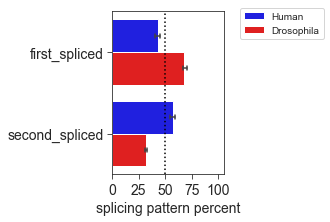

In [12]:
# Plot for Figure S6E

# get splicing order dataframe for S2 cells
K562_1_splicing_order_df = get_both_splicing_order_df(K562_1_intron_pairs_df)
K562_2_splicing_order_df = get_both_splicing_order_df(K562_2_intron_pairs_df)
K562_3_splicing_order_df = get_both_splicing_order_df(K562_3_intron_pairs_df)
K562_4_splicing_order_df = get_both_splicing_order_df(K562_4_intron_pairs_df)
K562_5_splicing_order_df = get_both_splicing_order_df(K562_5_intron_pairs_df)

# get splicing order dataframe for S2 cells
S2_1_splicing_order_df = get_both_splicing_order_df(S2_1_intron_pairs_df)
S2_2_splicing_order_df = get_both_splicing_order_df(S2_2_intron_pairs_df)
S2_3_splicing_order_df = get_both_splicing_order_df(S2_3_intron_pairs_df)

K562_splicing_order_df = pd.concat([K562_1_splicing_order_df,K562_2_splicing_order_df,K562_3_splicing_order_df,K562_4_splicing_order_df,K562_5_splicing_order_df]).reset_index(drop=True)
K562_splicing_order_df['name'] = 'Human'

S2_splicing_order_df = pd.concat([S2_1_splicing_order_df,S2_2_splicing_order_df,S2_3_splicing_order_df])
S2_splicing_order_df['name'] = 'Drosophila'

all_splicing_order_df = pd.concat([K562_splicing_order_df,S2_splicing_order_df])
                                   
fig, ax = plt.subplots(figsize=(2,3))

sns.barplot(x="splicing_status", y="order", hue="name", data=all_splicing_order_df, palette=['blue','red'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlabel("splicing pattern percent", fontsize=14)
plt.ylabel("", fontsize=14)

plt.xticks([0,25,50,75,100], fontsize=12)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(0,105)
plt.axvline(x=50, color='black', linestyle=":")

plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.savefig('/path/to/Supplemental_Figure_6E_K562_S2_splicing_order_mediumStringencyOnly.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()




In [30]:
print("K562 first spliced counts: "+str(np.sum(K562_splicing_order_counts['yes_no'])))
print("K562 second spliced counts: "+str(np.sum(K562_splicing_order_counts['no_yes'])))
      
p = stats.binom_test([np.sum(K562_splicing_order_counts['yes_no']),np.sum(K562_splicing_order_counts['no_yes'])], n=None, p=0.5)
print("K562 p-value: "+str(p))

K562 first spliced counts: 1546
K562 second spliced counts: 1861
K562 p-value: 7.316980092432492e-08


In [31]:
print("S2 first spliced counts: "+str(np.sum(S2_splicing_order_counts['yes_no'])))
print("S2 second spliced counts: "+str(np.sum(S2_splicing_order_counts['no_yes'])))

p = stats.binom_test([np.sum(S2_splicing_order_counts['yes_no']),np.sum(S2_splicing_order_counts['no_yes'])], n=None, p=0.5)
print("S2 p-value: "+str(p))

S2 first spliced counts: 2546
S2 second spliced counts: 1169
S2 p-value: 1.571688436039547e-115


In [ ]:
# SUPPLEMENTAL FIGURES 6G and 6H

In [4]:
# function to get a bedtool file with intron coordinate info from hg38 intron bed file
def get_hg38_introns(intronFile):
    
    # make a list for all intron coordinates
    introns = []

    # loop through a file with intron coordinates
    # record features about the introns
    for line in intronFile:
        chrom = str(line.split('\t')[0])                  # chromosome
        start = line.split('\t')[1]                       # start coordinate of intron (last base of exon)
        end = line.split('\t')[2]                         # end coordinate of intron (last base of intron)
        name_split = line.split('\t')[3].split('_intron') # split name file by intron
        gene = name_split[0]                              # gene name
        feature = int(name_split[1].split('_')[1])+1      # intron count
        strand = line.split('\t')[5][0]                   # strand of gene with intron

        # make a key that will represent intron coordinates
        introns.append([str(chrom),str(start),str(end),str(gene),str(feature),str(strand)])

    # build bedtool with intron coordinates
    introns_bedtool = BedTool(introns)
    intronFile.close()
    return introns_bedtool


# function to get a bedtool file with splice site coordinate info from hg38 intron bed file
def get_hg38_5SSs(intronFile, window):

    # make a list for all 5'SS coordinates
    splice_sites = []

    # loop through a file with intron coordinates
    # record features about the introns
    for line in intronFile:
        chrom = str(line.split('\t')[0])                  # chromosome
        start = line.split('\t')[1]                       # start coordinate of intron (last base of exon)
        end = line.split('\t')[2]                         # end coordinate of intron (last base of intron)
        name_split = line.split('\t')[3].split('_intron') # split name file by intron
        gene = name_split[0]                              # gene name
        feature = int(name_split[1].split('_')[1])+1      # intron count
        strand = line.split('\t')[5][0]                   # strand of gene with intron

        # get 5' SS positions for introns on each strand
        if strand=='+':
            ss = int(start)
        if strand=='-':
            ss = int(end)

        # set boundaries around the splice sites for analysis
        ss_start = ss-window
        ss_end = ss+window

        splice_sites.append([str(chrom),str(ss_start),str(ss_end),str(gene),str(feature),str(strand)])
    
    bedtool_5SS = BedTool(splice_sites)
    intronFile.close()
    return bedtool_5SS


def get_intersect_df(bamFile, intron_info):

    bedFile = bamFile.bam_to_bed(cigar=True, tag='NM') # convert bam file to bed file, keep cigar string and NM (edit distance) tag
    intersect = bedFile.intersect(intron_info, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    intersect_df = intersect.to_dataframe(names=['chrom_read', 'start_read', 'end_read', 'name_read', 'qual_read', \
                                           'strand_read', 'cigar_read', 'chr_feature', 'start_feature', \
                                           'end_feature', 'name_gene', 'name_feature', 'strand_feature', 'count'], \
                               dtype={"chrom_read": str, "start_read": int, "end_read": int, \
                                     "name_read": str, "qual_read": int, "strand_read": str, "cigar_read": str, \
                                    "chr_feature": str, "start_feature": int, "end_feature": int, "name_gene": str, \
                                     "name_feature": str,"strand_feature": str, "count": int}) # convert to a dataframe

    return intersect_df


def get_SI_df(intersect_df):

    # prepare a list for distance between read end and 5SS
    dist = []
    
    # set variables for parsing the cigar string
    pattern = re.compile('([MIDNSHPX=])')
    Consumes_Query = ["M", "I", "S", "=", "X"]
    Consumes_Reference = ["M", "D", "N", "=", "X"]    

    for i in range(0,intersect_df.shape[0]):

        chrom = intersect_df.chrom_read.iloc[i]
        strand = intersect_df.strand_feature.iloc[i]
        name_read = intersect_df['name_read'].iloc[i]
        intron_count = intersect_df['name_feature'].iloc[i]
        name_gene = intersect_df['name_gene'].iloc[i]
        ss = (intersect_df.start_feature.iloc[i] + intersect_df.end_feature.iloc[i])/2    # record 5' splice site position

        # parse cigar string into a list of tuples for easy parsing
        Sep_Values = pattern.split(intersect_df.cigar_read[i])[:-1]
        CigarPairs = list((Sep_Values[n:n+2] for n in range(0, len(Sep_Values), 2)))  

        if strand == "-":
            align_3p_end = intersect_df.start_read.iloc[i]    # record 3' end of read
            dist_3p = ss-align_3p_end                         # record distance between read end and splice site

            # get RNA end softclip length
            if(CigarPairs[0][1]=='S'):
                end_clip=CigarPairs[0][0]
            elif(CigarPairs[0][1]=='H'):
                end_clip=CigarPairs[0][0]
            elif(CigarPairs[0][1]!='S' or CigarPairs[0][1]!='H'):
                end_clip=0

        if strand == "+":
            align_3p_end = intersect_df.end_read.iloc[i]      # record 3' end of read
            dist_3p = align_3p_end-ss                         # record distance between read end and splice site

        # get RNA end softclip length
            last=len(CigarPairs)
            if(CigarPairs[last-1][1]=='S'):
                end_clip=CigarPairs[last-1][0]
            elif(CigarPairs[last-1][1]=='H'):
                end_clip=CigarPairs[last-1][0]
            elif(CigarPairs[last-1][1]!='S' or CigarPairs[last-1][1]!='H'):
                end_clip=0

        if ((dist_3p == 0) and (int(end_clip) <= 75)):
            dist.append([name_read,chrom,ss,strand,name_gene,intron_count])

    distance_df = pd.DataFrame(dist)
    distance_df.columns = ['read_name','chrom','position','strand','gene','intron_count']
    distance_df = distance_df.drop_duplicates(keep=False).reset_index(drop=True)
    
    return distance_df



# function to create a dataframe with splicing information for
# every read that spans an intron in the dataset
def get_splicing_info(intersect_df, min_overlap):
    
    df = intersect_df

    # prepare a list for splice calls
    spliceCalls = []

    # set variables for parsing the cigar string
    pattern = re.compile('([MIDNSHPX=])')
    Consumes_Query = ["M", "I", "S", "=", "X"]
    Consumes_Reference = ["M", "D", "N", "=", "X"]    

    # loop through all read-intron intersects
    for i in range(0,df.shape[0]):

        # ignore reads that do not overlap intron by minimum threshold
        if (df['count'].iloc[i] < min_overlap):
            continue

        # record the start and ends of reads 
        # will deal with gene strand after cigar counts are made
        aln_start = df['start_aln'].iloc[i] # record the start of the read
        aln_end = df['end_aln'].iloc[i] # record the end of the read
        intron_start = df['start_intron'].iloc[i] # record the end of the intron
        intron_end = df['end_intron'].iloc[i] # record the end of the intron

        # parse cigar string into a list of tuples for easy parsing
        Sep_Values = pattern.split(df['cigar_aln'].iloc[i])[:-1]
        CigarPairs = list((Sep_Values[n:n+2] for n in range(0, len(Sep_Values), 2)))  

        # set up variables for measuring the length of cigar string operators
        CigarOp_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        start_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        end_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        intron_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        currentloc = int(df['start_aln'].iloc[i])

        # go through list of cigar strings and grab splicing information
        for cigar_Entry in CigarPairs:

            op_Length = int(cigar_Entry[0]) # get length of cigar operator
            cigarOp = cigar_Entry[1] # get type of cigar operator  
            CigarOp_counts[cigarOp] += op_Length # add the cigar operator length to the counts dictionary
            cigarOp_start=currentloc # get the starting coordinate of the cigar operator

            if (cigarOp in Consumes_Reference):
                currentloc=currentloc+op_Length # add the cigar operator length to the current location coordinate 

            cigarOp_end=currentloc # get the ending coordinate of the cigar operator

            # gather information if the portion of the cigar string spans the designated intron start
            if (cigarOp_start<intron_start-min_overlap and cigarOp_end>=intron_start-min_overlap):
                if (cigarOp_end>=intron_start+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_start-min_overlap)+1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start-min_overlap and cigarOp_end<intron_start+min_overlap):
                count=op_Length
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary       

            elif (cigarOp_start<intron_start+min_overlap and cigarOp_end>=intron_start+min_overlap):
                if (cigarOp_start<=intron_start-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_start+min_overlap)-cigarOp_start-1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string is within the intron
            if (cigarOp_start<intron_start and cigarOp_end>=intron_start):
                if (cigarOp_end>=intron_end):
                    count=intron_end-intron_start
                else:
                    count=cigarOp_end-intron_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start and cigarOp_end<intron_end):
                count=op_Length
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end and cigarOp_end>=intron_end):
                if (cigarOp_start<=intron_start):
                    count=intron_end-intron_start
                else:
                    count=intron_end-cigarOp_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string spans the designated intron end
            if (cigarOp_start<intron_end-min_overlap and cigarOp_end>=intron_end-min_overlap):
                if (cigarOp_end>=intron_end+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_end-min_overlap)
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_end-min_overlap and cigarOp_end<intron_end+min_overlap):
                count=op_Length
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end+min_overlap and cigarOp_end>=intron_end+min_overlap):
                if (cigarOp_start<=intron_end-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_end+min_overlap)-cigarOp_start
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

        # get length of the aligned portion of this read from cigar string
        aligned_read_length = CigarOp_counts['M']+CigarOp_counts['D']

        # get 5'SS and 3'SS counts as determined by gene strand
        strand = df['strand_gene'].iloc[i]
        if (strand == '+'):
            aln_start = df['start_aln'].iloc[i] # record the start of the read
            aln_end = df['end_aln'].iloc[i] # record the end of the read
            intron_5SS_counts = start_counts # record the cigar string counts over the 5'SS
            intron_3SS_counts = end_counts # record the cigar string counts over the 3'SS
            read_overlap = intron_end - (aln_end - aligned_read_length + min_overlap)
            
        if (strand == '-'):
            aln_start = df['end_aln'].iloc[i] # record the start of the read
            aln_end = df['start_aln'].iloc[i] # record the end of the read
            intron_5SS_counts = end_counts # record the cigar string counts over the 5'SS
            intron_3SS_counts = start_counts # record the cigar string counts over the 3'SS  
            read_overlap = (aln_end + aligned_read_length - min_overlap) - intron_start
            
        # annotate splicing status based on CIGAR string information around splice sites
        splice='UNDETERMINED'

        if (intron_5SS_counts['N']==0 and intron_3SS_counts['N']==0):
            if (intron_3SS_counts['M']+intron_3SS_counts['D']==min_overlap*2):
                if (intron_3SS_counts['M']>min_overlap):
                    splice = 'NO'

        if (intron_5SS_counts['N']>0 and intron_5SS_counts['N']<min_overlap*2):
            if (intron_3SS_counts['N']>0 and intron_3SS_counts['N']<min_overlap*2):
                splice = 'YES'

        # annotate splicing status based on CIGAR string information within the intron 
        if (splice == 'YES'):
            if (float(intron_end-intron_start) > 0.0):
                ratio = float(intron_counts['N'])/float(intron_end-intron_start)
                difference = abs(intron_counts['N']-(intron_end-intron_start))

                # if read is spliced, between 90-100% of the intron has to be spliced 
                # and no more than 100 nucleotides within the intron can be matching the intron sequence
                if( ratio < 0.9 or ratio > 1.1 or difference > 100):
                    splice='UNDETERMINED'
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'

        if (splice == 'NO'):
            if (float(intron_end-intron_start) > 0.0):
                ratio = float(intron_counts['M'])/(float(intron_counts['M'])+float(intron_counts['N'])+float(intron_counts['D'])+1)

                # if read is unspliced, at least 75% of the read has to match (CIGAR=M) the intron sequence
                if(intron_counts['M'] < min_overlap/2 or ratio < 0.75):
                    splice='UNDETERMINED'
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'

        # save read, intron, and splicing information
        spliceCalls.append([df['name_aln'].iloc[i],df['chr_intron'].iloc[i],intron_start,intron_end,df['strand_gene'].iloc[i],df['name_gene'].iloc[i],df['intron_count'].iloc[i],read_overlap,splice])

    spliceCalls_df = pd.DataFrame(spliceCalls)
    spliceCalls_df.columns = ["read_name","chrom","intron_start","intron_end","strand","gene_name","intron_count","read_overlap","splice_status"]

    return spliceCalls_df


# function to create a dataframe with splicing information for
# introns that are upstream of an intron with a splicing intermediate read end
def get_SI_splicing_info(bamFile, introns_bedtool, SI_df, min_overlap):
    
    SI_read_names = set(SI_df['read_name'])
    
    # get reads that span 3' splice sites and convert to a dataframe
    bedFile = bamFile.bam_to_bed(cigar=True, tag='NM') # convert bam file to bed file, keep cigar string and NM (edit distance) tag
    SI_bedTool = bedFile.filter(lambda b: b.name in SI_read_names)
    SI_bedTool = SI_bedTool.saveas()

    # function to create a dataframe with SI reads that span intron coordinates
    intersect = SI_bedTool.intersect(introns_bedtool, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    splicingReads = intersect.to_dataframe(names=['chr_aln', 'start_aln', 'end_aln', 'name_aln', 'qual_aln', \
                                           'strand_aln', 'cigar_aln', 'chr_intron', 'start_intron', \
                                           'end_intron', 'name_gene', 'intron_count', 'strand_gene', 'count'], \
                               dtype={"chr_aln": str, "start_aln": int, "end_aln": int, \
                                     "name_aln": str, "qual_aln": int, "strand_aln": str, \
                                     "cigar_aln": str, "chr_intron": str, "start_intron": int, \
                                     "end_intron": int, "name_gene": str, \
                                     "intron_count": int,"strand_gene": str, "count": int}) # convert to a dataframe

    splicingCalls = get_splicing_info(splicingReads, min_overlap) #determine splicing status and distance

    # function to get a dataframe with splicing info for only the introns that are upstream of a SI
    SI_upstream_introns = []

    for i in range(len(splicingCalls)):
        read_name = splicingCalls.iloc[i]['read_name']
        gene_name = splicingCalls.iloc[i]['gene_name']
        intron_count = splicingCalls.iloc[i]['intron_count']

        match = SI_df[SI_df['read_name']==read_name]
        SI_gene = match['gene'].values[0]
        SI_intron_count = int(match['intron_count'].values[0])

        if (SI_gene==gene_name):
            if (abs(intron_count-SI_intron_count)==1):

                SI_upstream_introns.append(splicingCalls.iloc[i].tolist())

    match_spliceCalls_df = pd.DataFrame(SI_upstream_introns)
    match_spliceCalls_df.columns = ["read_name","chrom","intron_start","intron_end","strand","gene_name","intron_count","read_overlap","splice_status"]

    spliced = len(match_spliceCalls_df[match_spliceCalls_df['splice_status']=="YES"])
    unspliced = len(match_spliceCalls_df[match_spliceCalls_df['splice_status']=="NO"])
    undetermined = len(match_spliceCalls_df[match_spliceCalls_df['splice_status']=="UNDETERMINED"])
    percent_spliced = float(spliced) / float(spliced + unspliced) * 100
    
    splice_count = []
    splice_count.append([spliced,unspliced,percent_spliced])
    splice_count_df = pd.DataFrame(splice_count)
    splice_count_df.columns = ['spliced','unspliced','percent_spliced']
    
    return match_spliceCalls_df, splice_count_df


### S2 specific ###

# function to get a bedtool file with intron coordinate info from hg38 intron bed file
def get_S2_introns(intronFile):
    
    # make a list for all intron coordinates
    introns = []

    # loop through a file with intron coordinates
    # record features about the introns
    for line in intronFile:
        chrom = "chr"+str(line.split('\t')[0])                  # chromosome
        start = line.split('\t')[1]                       # start coordinate of intron (last base of exon)
        end = line.split('\t')[2]                         # end coordinate of intron (last base of intron)
        name_split = line.split('\t')[3].split('_intron') # split name file by intron
        gene = name_split[0]                              # gene name
        feature = int(name_split[1].split('_')[1])+1      # intron count
        strand = line.split('\t')[5][0]                   # strand of gene with intron

        # make a key that will represent intron coordinates
        introns.append([str(chrom),str(start),str(end),str(gene),str(feature),str(strand)])

    # build bedtool with intron coordinates
    introns_bedtool = BedTool(introns)
    intronFile.close()
    return introns_bedtool


# function to get a bedtool file with splice site coordinate info from hg38 intron bed file
def get_S2_5SSs(intronFile, window):

    # make a list for all 5'SS coordinates
    splice_sites = []

    # loop through a file with intron coordinates
    # record features about the introns
    for line in intronFile:
        chrom = "chr"+str(line.split('\t')[0])                  # chromosome
        start = line.split('\t')[1]                       # start coordinate of intron (last base of exon)
        end = line.split('\t')[2]                         # end coordinate of intron (last base of intron)
        name_split = line.split('\t')[3].split('_intron') # split name file by intron
        gene = name_split[0]                              # gene name
        feature = int(name_split[1].split('_')[1])+1      # intron count
        strand = line.split('\t')[5][0]                   # strand of gene with intron

        # get 5' SS positions for introns on each strand
        if strand=='+':
            ss = int(start)
        if strand=='-':
            ss = int(end)

        # set boundaries around the splice sites for analysis
        ss_start = ss-window
        ss_end = ss+window

        splice_sites.append([str(chrom),str(ss_start),str(ss_end),str(gene),str(feature),str(strand)])
    
    bedtool_5SS = BedTool(splice_sites)
    intronFile.close()
    return bedtool_5SS


In [6]:
# make a bedtool with intron coordinates
K562_intronFile = open('/path/to/annotation_files/NCBI_RefSeq_hg38_introns_parsed.bed')
K562_introns_bedtool = get_hg38_introns(K562_intronFile) 

# make a bedtool with 5'SS coordinates
K562_intronFile = open('/path/to/annotation_files/NCBI_RefSeq_hg38_introns_parsed.bed')
window = 5
K562_5SS_bedtool = get_hg38_5SSs(K562_intronFile, window) 


In [7]:
# upload alignment files
K562_1_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_1_hg38_minimap2_uniq_sort.bam')
K562_2_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_2_hg38_minimap2_uniq_sort.bam')
K562_3_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_3_hg38_minimap2_uniq_sort.bam')
K562_4_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_4_hg38_minimap2_uniq_sort.bam')
K562_5a_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_5a_hg38_minimap2_uniq_sort.bam')
K562_5b_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_5b_hg38_minimap2_uniq_sort.bam')

# get alignment and intron junction intersections
K562_1_intersect_df = get_intersect_df(K562_1_bamFile, K562_5SS_bedtool)
K562_2_intersect_df = get_intersect_df(K562_2_bamFile, K562_5SS_bedtool)
K562_3_intersect_df = get_intersect_df(K562_3_bamFile, K562_5SS_bedtool)
K562_4_intersect_df = get_intersect_df(K562_4_bamFile, K562_5SS_bedtool)
K562_5a_intersect_df = get_intersect_df(K562_5a_bamFile, K562_5SS_bedtool)
K562_5b_intersect_df = get_intersect_df(K562_5b_bamFile, K562_5SS_bedtool)

# get dataframe with information from reads that end at splice sites
K562_1_SI_df = get_SI_df(K562_1_intersect_df)
K562_2_SI_df = get_SI_df(K562_2_intersect_df)
K562_3_SI_df = get_SI_df(K562_3_intersect_df)
K562_4_SI_df = get_SI_df(K562_4_intersect_df)
K562_5a_SI_df = get_SI_df(K562_5a_intersect_df)
K562_5b_SI_df = get_SI_df(K562_5b_intersect_df)

# get dataframe with splicing information from introns just upstream of SI read ends
min_overlap = 25

K562_1_match_spliceCalls_df, K562_1_SI_splicing_df = get_SI_splicing_info(K562_1_bamFile, K562_introns_bedtool, K562_1_SI_df, min_overlap)
K562_2_match_spliceCalls_df, K562_2_SI_splicing_df = get_SI_splicing_info(K562_2_bamFile, K562_introns_bedtool, K562_2_SI_df, min_overlap)
K562_3_match_spliceCalls_df, K562_3_SI_splicing_df = get_SI_splicing_info(K562_3_bamFile, K562_introns_bedtool, K562_3_SI_df, min_overlap)
K562_4_match_spliceCalls_df, K562_4_SI_splicing_df = get_SI_splicing_info(K562_4_bamFile, K562_introns_bedtool, K562_4_SI_df, min_overlap)
K562_5a_match_spliceCalls_df, K562_5a_SI_splicing_df = get_SI_splicing_info(K562_5a_bamFile, K562_introns_bedtool, K562_5a_SI_df, min_overlap)
K562_5b_match_spliceCalls_df, K562_5b_SI_splicing_df = get_SI_splicing_info(K562_5b_bamFile, K562_introns_bedtool, K562_5b_SI_df, min_overlap)


In [11]:
# make a bedtool with intron coordinates
S2_intronFile = open('/path/to/annotation_files/dm6_RefSeq_introns_parsed.bed')
S2_introns_bedtool = get_S2_introns(S2_intronFile) 

# make a bedtool with 5'SS coordinates
S2_intronFile = open('/path/to/annotation_files/dm6_RefSeq_introns_parsed.bed')
window = 5
S2_5SS_bedtool = get_S2_5SSs(S2_intronFile, window) 


In [12]:
# upload alignment files
S2_1a_bamFile = pybedtools.BedTool('/path/to/S2_4sUchr_ONT_1a_dm6_minimap2_uniq_sort.bam')
S2_1b_bamFile = pybedtools.BedTool('/path/to/S2_4sUchr_ONT_1b_dm6_minimap2_uniq_sort.bam')
S2_2_bamFile = pybedtools.BedTool('/path/to/S2_4sUchr_ONT_2_dm6_minimap2_uniq_sort.bam')
S2_2_bamFile = pybedtools.BedTool('/path/to/S2_4sUchr_ONT_3_dm6_minimap2_uniq_sort.bam')

# get alignment and intron junction intersections
S2_1a_intersect_df = get_intersect_df(S2_1a_bamFile, S2_5SS_bedtool)
S2_1b_intersect_df = get_intersect_df(S2_1b_bamFile, S2_5SS_bedtool)
S2_2_intersect_df = get_intersect_df(S2_2_bamFile, S2_5SS_bedtool)
S2_3_intersect_df = get_intersect_df(S2_3_bamFile, S2_5SS_bedtool)

# get dataframe with information from reads that end at splice sites
S2_1a_SI_df = get_SI_df(S2_1a_intersect_df)
S2_1b_SI_df = get_SI_df(S2_1b_intersect_df)
S2_2_SI_df = get_SI_df(S2_2_intersect_df)
S2_3_SI_df = get_SI_df(S2_3_intersect_df)

# get dataframe with splicing information from introns just upstream of SI read ends
min_overlap = 25

S2_1a_match_spliceCalls_df, S2_1a_SI_splicing_df = get_SI_splicing_info(S2_1a_bamFile, S2_introns_bedtool, S2_1a_SI_df, min_overlap)
S2_1b_match_spliceCalls_df, S2_1b_SI_splicing_df = get_SI_splicing_info(S2_1b_bamFile, S2_introns_bedtool, S2_1b_SI_df, min_overlap)
S2_2_match_spliceCalls_df, S2_2_SI_splicing_df = get_SI_splicing_info(S2_2_bamFile, S2_introns_bedtool, S2_2_SI_df, min_overlap)
S2_3_match_spliceCalls_df, S2_3_SI_splicing_df = get_SI_splicing_info(S2_3_bamFile, S2_introns_bedtool, S2_3_SI_df, min_overlap)

S2_1_SI_splicing_df = S2_1a_SI_splicing_df.copy()
S2_1_SI_splicing_df['spliced'] = S2_1a_SI_splicing_df['spliced'] + S2_1b_SI_splicing_df['spliced']
S2_1_SI_splicing_df['unspliced'] = S2_1a_SI_splicing_df['unspliced'] + S2_1b_SI_splicing_df['unspliced']
S2_1_SI_splicing_df['percent_spliced'] = S2_1_SI_splicing_df['spliced']/(S2_1_SI_splicing_df['spliced']+S2_1_SI_splicing_df['unspliced'])*100.0


In [ ]:
### Supplemental Figure S6G

In [25]:
# get coordinates of human introns
hg38_intron_info = pd.read_table('/path/to/annotation_files/hg38_all_intron_features.txt')
hg38_intron_info = hg38_intron_info[['chrom','start','end','name','intron_length','strand']]


In [26]:
# merge splice intermediate introns with intron coordinate file to get intron lengths
K562_SI_df = pd.concat([HL6_SI_df, HL7_SI_df, HL12_SI_df, HL27_SI_df, Pr1_SI_df])
K562_SI_df['intron_count'] = K562_SI_df['intron_count'].apply(lambda x: int(x)-1)
K562_SI_df['name'] = K562_SI_df['gene']+'_intron_'+K562_SI_df['intron_count'].astype(str)
K562_SI_df['chrom'] = 'chr'+K562_SI_df['chrom'].astype(str)

K562_intron_length_SI_df = pd.merge(K562_SI_df, hg38_intron_info, on=['name'], how='left')[['read_name','name','intron_length']]


In [27]:
# merge splice intermediate introns with upstream introns to get a list of all downstream introns in plot
K562_upstream_introns_SI_df = pd.concat([K562_1_match_spliceCalls_df, K562_2_match_spliceCalls_df, K562_3_match_spliceCalls_df, K562_4_match_spliceCalls_df, K562_5a_match_spliceCalls_df,K562_5b_match_spliceCalls_df])
K562_downstream_introns_SI_df = pd.merge(K562_intron_length_SI_df, K562_upstream_introns_SI_df, on=['read_name'], how='inner')[['read_name','name','intron_length']]
K562_downstream_introns_SI_df = K562_downstream_introns_SI_df.drop_duplicates(subset=['read_name']).reset_index(drop=True)


In [28]:
# get lengths of all upstream introns in plot
K562_upstream_introns_SI_df['intron_length'] = K562_upstream_introns_SI_df['intron_end']-K562_upstream_introns_SI_df['intron_start']


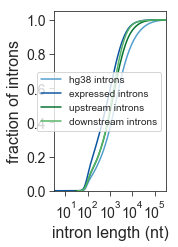

In [53]:
# plot length distribution of upstream and downstream introns deriving from splicing intermediates
hg38_intron_info = hg38_intron_info.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(2,3.3))

hg38_intron_lengths = np.log10(hg38_intron_info['intron_length'].values)
K562_upstream_lengths = np.log10(K562_upstream_introns_SI_df['intron_length'].values)
K562_downstream_lengths = np.log10(K562_downstream_introns_SI_df['intron_length'].values)
K562_introns_expr_lengths = np.log10(K562_introns['intron_length'].values)

ax = sns.distplot(hg38_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], bins=np.max(hg38_intron_info['intron_length']), label='hg38 introns')
sns.distplot(K562_introns_expr_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[5], bins=np.max(hg38_intron_info['intron_length']), label='expressed introns')
sns.distplot(K562_upstream_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[5], bins=np.max(hg38_intron_info['intron_length']), label='upstream introns')
sns.distplot(K562_downstream_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[3], bins=np.max(hg38_intron_info['intron_length']), label='downstream introns')

x_labels = ["$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$","$\mathregular{10^{5}}$"]
plt.xticks([1,2,3,4,5], x_labels, fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(0.5,5.5)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("fraction of introns", fontsize=16)
ax.set_xlabel("intron length (nt)", fontsize=16)

plt.savefig('/path/to/Supplemental_Figure_6G_K562_SI_intron_length_cumdist_plot_updated.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [44]:
# get coordinates of drosophila introns
dm6_intron_info = pd.read_table('/path/to/annotation_files/dmel6_all_intron_features.txt')
dm6_intron_info = dm6_intron_info[['chrom','start','end','name','intron_length','strand']]


In [45]:
# merge splice intermediate introns with intron coordinate file to get intron lengths
S2_SI_df = pd.concat([S2_1a_SI_df, S2_1b_SI_df, S2_2_SI_df, S2_3_SI_df])
S2_SI_df['intron_count'] = S2_SI_df['intron_count'].apply(lambda x: int(x)-1)
S2_SI_df['name'] = S2_SI_df['gene']+'_intron_'+S2_SI_df['intron_count'].astype(str)
S2_SI_df['chrom'] = 'chr'+S2_SI_df['chrom'].astype(str)

S2_intron_length_SI_df = pd.merge(S2_SI_df, dm6_intron_info, on=['name'], how='left')[['read_name','name','intron_length']]


In [46]:
# merge splice intermediate introns with upstream introns to get a list of all downstream introns in plot
S2_upstream_introns_SI_df = pd.concat([S2_1a_match_spliceCalls_df, S2_1b_match_spliceCalls_df, S2_2_match_spliceCalls_df, S2_3_match_spliceCalls_df])
S2_downstream_introns_SI_df = pd.merge(S2_intron_length_SI_df, S2_upstream_introns_SI_df, on=['read_name'], how='inner')[['read_name','name','intron_length']]
S2_downstream_introns_SI_df = S2_downstream_introns_SI_df.drop_duplicates(subset=['read_name']).reset_index(drop=True)


In [47]:
# get lengths of all upstream introns in plot
S2_upstream_introns_SI_df['intron_length'] = S2_upstream_introns_SI_df['intron_end']-S2_upstream_introns_SI_df['intron_start']


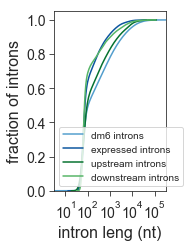

In [54]:
# plot length distribution of upstream and downstream introns deriving from splicing intermediates
dm6_intron_info = dm6_intron_info.drop_duplicates(subset=['chrom','start','end','strand']).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(2,3.3))

dm6_intron_lengths = np.log10(dm6_intron_info['intron_length'].values)
S2_upstream_lengths = np.log10(S2_upstream_introns_SI_df['intron_length'].values)
S2_downstream_lengths = np.log10(S2_downstream_introns_SI_df['intron_length'].values)
S2_introns_expr_lengths = np.log10(S2_introns['intron_length'].values)

ax = sns.distplot(dm6_intron_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], bins=np.max(hg38_intron_info['intron_length']), label='dm6 introns')
sns.distplot(S2_introns_expr_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[5], bins=np.max(hg38_intron_info['intron_length']), label='expressed introns')
sns.distplot(S2_upstream_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[5], bins=np.max(hg38_intron_info['intron_length']), label='upstream introns')
sns.distplot(S2_downstream_lengths, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Greens")[3], bins=np.max(hg38_intron_info['intron_length']), label='downstream introns')

x_labels = ["$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$","$\mathregular{10^{5}}$"]
plt.xticks([1,2,3,4,5], x_labels, fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(0.5,5.5)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("fraction of introns", fontsize=16)
ax.set_xlabel("intron leng (nt)", fontsize=16)
#ax.legend(fontsize=14)

plt.savefig('/path/to/Supplemental_Figure_6G_S2_SI_intron_length_cumdist_plot_updated.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
### Supplementary Figure S6H

In [25]:
# get dataframe with information from reads that end at splice sites

K562_5_SI_df = pd.concat([K562_5a_SI_df,K562_5b_SI_df],axis=0)

min_overlap = 25
K562_5_bamFile = pybedtools.BedTool('/path/to/K562_4sUchr_ONT_5_hg38_minimap2_uniq_sort.bam') # merged BAM file from replicates 5a and 5b

K562_5_match_spliceCalls_df, K562_5_SI_splicing_df = get_SI_splicing_info(K562_5_bamFile, K562_introns_bedtool, K562_5_SI_df, min_overlap)


In [26]:
# combining K562 and S2 datasets to plot them together

K562_SI_splicing_df = pd.concat([K562_1_SI_splicing_df,K562_2_SI_splicing_df,K562_3_SI_splicing_df,K562_4_SI_splicing_df,K562_5_SI_splicing_df])
K562_SI_splicing_df['name'] = ['Human','Human','Human','Human','Human']

S2_1_SI_splicing_df = S2_1a_SI_splicing_df.copy()
S2_1_SI_splicing_df['spliced'] = S2_1a_SI_splicing_df['spliced'] + S2_1b_SI_splicing_df['spliced']
S2_1_SI_splicing_df['unspliced'] = S2_1a_SI_splicing_df['unspliced'] + S2_1b_SI_splicing_df['unspliced']
S2_1_SI_splicing_df['percent_spliced'] = S2_1_SI_splicing_df['spliced']/(S2_1_SI_splicing_df['spliced']+S2_1_SI_splicing_df['unspliced'])*100.0

S2_SI_splicing_df = pd.concat([S2_1_SI_splicing_df,S2_2_SI_splicing_df,S2_3_SI_splicing_df])
S2_SI_splicing_df['name'] = ['Drosophila','Drosophila','Drosophila']

all_SI_splicing_df = pd.concat([K562_SI_splicing_df,S2_SI_splicing_df])
all_SI_splicing_df = all_SI_splicing_df.reset_index(drop=True)
all_SI_splicing_df

,spliced,unspliced,percent_spliced,name
0,303,695,30.360721,Human
1,57,83,40.714286,Human
2,444,812,35.350318,Human
3,2099,2363,47.041685,Human
4,2287,2511,47.665694,Human
5,1013,889,53.259727,Drosophila
6,948,814,53.802497,Drosophila
7,850,731,53.763441,Drosophila


In [31]:
K562_SI_splicing_df

,spliced,unspliced,percent_spliced,name
0,303,695,30.360721,Human
0,57,83,40.714286,Human
0,444,812,35.350318,Human
0,2099,2363,47.041685,Human
0,2287,2511,47.665694,Human


In [27]:
np.sum(all_SI_splicing_df[all_SI_splicing_df['name']=="Human"]['spliced'])

5190

In [28]:
np.sum(all_SI_splicing_df[all_SI_splicing_df['name']=="Human"]['unspliced'])

6464

In [29]:
np.sum(all_SI_splicing_df[all_SI_splicing_df['name']=="Drosophila"]['spliced'])

2811

In [30]:
np.sum(all_SI_splicing_df[all_SI_splicing_df['name']=="Drosophila"]['unspliced'])

2434

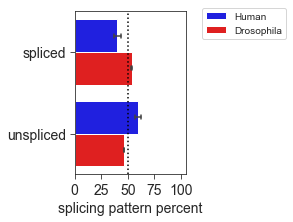

In [51]:
# Plot for Figure S6H

all_SI_splicing_df['percent_unspliced']=all_SI_splicing_df['unspliced'].astype(float)/(all_SI_splicing_df['spliced'].astype(float)+all_SI_splicing_df['unspliced'].astype(float))*100
all_SI = []

for i in range(len(all_SI_splicing_df)):
    all_SI.append(['spliced',all_SI_splicing_df.iloc[i]['percent_spliced'],all_SI_splicing_df.iloc[i]['name']])
    all_SI.append(['unspliced',all_SI_splicing_df.iloc[i]['percent_unspliced'],all_SI_splicing_df.iloc[i]['name']])
    
all_SI_df = pd.DataFrame(all_SI)
all_SI_df.columns = ['status','percent','species']


fig, ax = plt.subplots(figsize=(2,3))

sns.barplot(x="percent", y="status", hue="species", data=all_SI_df, palette=['blue','red'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlabel("splicing pattern percent", fontsize=14)
plt.ylabel("", fontsize=14)

plt.xticks([0,25,50,75,100], fontsize=12)
ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(0,105)
plt.axvline(x=50, color='black', linestyle=":")

plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.savefig('/path/to/Supplemental_Figure_6H_K562_S2_SI_splicing_order_horizontal_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()



In [32]:
print("K562 upstream intron spliced counts: "+str(np.sum(K562_SI_splicing_df['spliced'])))
print("K562 upstream intron unspliced counts: "+str(np.sum(K562_SI_splicing_df['unspliced'])))
      
p = stats.binom_test([np.sum(K562_SI_splicing_df['spliced']),np.sum(K562_SI_splicing_df['unspliced'])], n=None, p=0.5)
print("K562 p-value: "+str(p))

K562 upstream intron spliced counts: 5190
K562 upstream intron unspliced counts: 6464
K562 p-value: 3.7314626577854597e-32


In [33]:
print("S2 upstream intron spliced counts: "+str(np.sum(S2_SI_splicing_df['spliced'])))
print("S2 upstream intron unspliced counts: "+str(np.sum(S2_SI_splicing_df['unspliced'])))
      
p = stats.binom_test([np.sum(S2_SI_splicing_df['spliced']),np.sum(S2_SI_splicing_df['unspliced'])], n=None, p=0.5)
print("S2 p-value: "+str(p))

S2 upstream intron spliced counts: 2811
S2 upstream intron unspliced counts: 2434
S2 p-value: 2.0592187084403015e-07


In [ ]:
### Files for Supplemental Figs 6I-K

In [70]:
# upload files from directory
K562_1_intron_pairs_df = pd.read_table("/path/to/K562_1_hg38_intron_pairs_df.txt",header=0)
K562_2_intron_pairs_df = pd.read_table("/path/to/K562_2_hg38_intron_pairs_df.txt",header=0)
K562_3_intron_pairs_df = pd.read_table("/path/to/K562_3_hg38_intron_pairs_df.txt",header=0)
K562_4_intron_pairs_df = pd.read_table("/path/to/K562_4_hg38_intron_pairs_df.txt",header=0)
K562_5a_intron_pairs_df = pd.read_table("/path/to/K562_5a_hg38_intron_pairs_df.txt",header=0)
K562_5b_intron_pairs_df = pd.read_table("/path/to/K562_5b_hg38_intron_pairs_df.txt",header=0)
K562_5_intron_pairs_df = pd.concat([K562_5a_intron_pairs_df,K562_5b_intron_pairs_df],axis=0)


In [71]:
# upload files from directory
S2_1_intron_pairs_df = pd.read_table("/path/to/S2_1_dm6_intron_pairs_df.txt",header=0)
S2_2_intron_pairs_df = pd.read_table("/path/to/S2_2_dm6_intron_pairs_df.txt",header=0)
S2_3_intron_pairs_df = pd.read_table("/path/to/S2_3_dm6_intron_pairs_df.txt",header=0)


In [72]:
# concatenate samples to get pairs

K562_intron_pairs_df = pd.concat([K562_1_intron_pairs_df, K562_2_intron_pairs_df, K562_3_intron_pairs_df, K562_4_intron_pairs_df, K562_5_intron_pairs_df], axis=0).reset_index(drop=True)
K562_intron_pairs_df['chrom'] = 'chr'+K562_intron_pairs_df['chrom']

S2_intron_pairs_df = pd.concat([S2_1_intron_pairs_df, S2_2_intron_pairs_df, S2_3_intron_pairs_df], axis=0).reset_index(drop=True)


In [73]:
# get intron info files for analysis 

hg38_intron_info = pd.read_table('/path/to/annotation_files/hg38_all_intron_features.txt')
hg38_intron_info = hg38_intron_info.drop_duplicates(subset=['chrom','start','end','strand'])

dm6_intron_info = pd.read_table('/path/to/annotation_files/dmel6_all_intron_features.txt')
dm6_intron_info = dm6_intron_info.drop_duplicates(subset=['chrom','start','end','strand'])


In [74]:
### Supplemental Fig 6I

In [107]:
def get_intron_order_lengths(intron_pairs_df, intron_info):
    
    length1 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int1_start','int1_end','strand'], right_on=['chrom','start','end','strand'], how='left')['intron_length']
    length2 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int2_start','int2_end','strand'], right_on=['chrom','start','end','strand'], how='left')['intron_length']

    combined = pd.concat([intron_pairs_df['read'],intron_pairs_df['int1_splice'],intron_pairs_df['int2_splice'],length1,length2,intron_pairs_df['strand']],axis=1)
    combined.columns = ['read','int1_splice','int2_splice','int1_length','int2_length','strand']

    combined = combined[(combined['int1_length']>0) & (combined['int2_length']>0)].reset_index(drop=True)
    
    # get lengths by transcription order
    txn = combined[combined['int1_splice']!=combined['int2_splice']].reset_index(drop=True)
    txn = txn[txn['int1_length']!=txn['int2_length']].reset_index(drop=True)
    txn_pos = pd.concat([txn[txn['strand']=='+']['int1_splice'],txn[txn['strand']=='+']['int2_splice'],txn[txn['strand']=='+']['int1_length'],txn[txn['strand']=='+']['int2_length']], axis=1).reset_index(drop=True)
    txn_neg = pd.concat([txn[txn['strand']=='-']['int2_splice'],txn[txn['strand']=='-']['int1_splice'],txn[txn['strand']=='-']['int2_length'],txn[txn['strand']=='-']['int1_length']], axis=1).reset_index(drop=True)
    txn_neg.columns = ['int1_splice','int2_splice','int1_length','int2_length']
    txn_all = pd.concat([txn_pos,txn_neg]).reset_index(drop=True)

    K562_txn_order = pd.concat([txn_all['int1_length'],txn_all['int2_length']], axis=1)
    K562_txn_order.columns = ['txn_1','txn_2']

    # get lengths by splicing order
    int_1_splice = txn_all[txn_all['int1_splice']=="YES"].reset_index(drop=True)
    int_1_splice_lengths = pd.concat([int_1_splice['int1_length'],int_1_splice['int2_length']], axis=1)
    int_1_splice_lengths.columns = ['splice_1_length','splice_2_length']

    int_2_splice = txn_all[txn_all['int2_splice']=="YES"].reset_index(drop=True)
    int_2_splice_lengths = pd.concat([int_2_splice['int2_length'],int_2_splice['int1_length']], axis=1)
    int_2_splice_lengths.columns = ['splice_1_length','splice_2_length']

    splice_order = pd.concat([int_1_splice_lengths,int_2_splice_lengths]).reset_index(drop=True)
    splice_order.columns = ['splice_1','splice_2']

    return splice_order


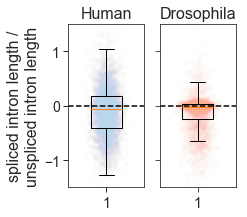

In [108]:
# get intron pair lengths
K562_splice_order_length_df = get_intron_order_lengths(K562_intron_pairs_df, hg38_intron_info)

S2_splice_order_length_df = get_intron_order_lengths(S2_intron_pairs_df, dm6_intron_info)

# plot distribution of intron lengths by splicing order

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(3,3))

# plotting length by splicing order K562 cells
y = np.log10(K562_splice_order_length_df['splice_1']/K562_splice_order_length_df['splice_2'])
x = np.random.normal(1, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax1.plot(x, y, '.', color=sns.color_palette("Blues")[1], alpha=0.01)

#y = K562_splice_order_3SSMaxEnt_df['splice_2']
#x = np.random.normal(2, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
#ax1.plot(x, y, '.', color=sns.color_palette("Blues")[1], alpha=0.01)

plot_list = np.log10(K562_splice_order_length_df['splice_1']/K562_splice_order_length_df['splice_2'])
ax1.boxplot(plot_list, 0, '', widths=0.4)

# plotting length by splicing order S2 cells
y = np.log10(S2_splice_order_length_df['splice_1']/S2_splice_order_length_df['splice_2'])
x = np.random.normal(1, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax2.plot(x, y, '.', color=sns.color_palette("Reds")[1], alpha=0.01)

#y = S2_splice_order_3SSMaxEnt_df['splice_2']
#x = np.random.normal(2, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
#ax2.plot(x, y, '.', color=sns.color_palette("Reds")[1], alpha=0.01)

plot_list = np.log10(S2_splice_order_length_df['splice_1']/S2_splice_order_length_df['splice_2'])
ax2.boxplot(plot_list, 0, '', widths=0.4)

ax1.axhline(y=0, color='black', linestyle='--')
ax2.axhline(y=0, color='black', linestyle='--')

ax1.set_ylabel("spliced intron length /\nunspliced intron length", fontsize=16)
ax1.set_title("Human", fontsize=16)
plt.title("Drosophila", fontsize=16)
    
plt.xticks(fontsize=14)
plt.ylim(-1.5,1.5)

ax1.xaxis.set_tick_params(labelsize=14, direction='out', length=5, width=1)
ax1.yaxis.set_tick_params(labelsize=14, direction='out', length=5, width=1)
ax1.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax2.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.savefig('/path/to/Supplemental_Figure_6I_K562_S2_intron_length_splicing_order_dif_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [109]:
print('K562 intron length (spliced>unspliced percent): '+str(float(len(K562_splice_order_length_df[np.log10(K562_splice_order_length_df['splice_1']/K562_splice_order_length_df['splice_2'])<0]))/float(len(K562_splice_order_length_df))))
print('S2 intron length (spliced>unspliced percent): '+str(float(len(S2_splice_order_length_df[np.log10(S2_splice_order_length_df['splice_1']/S2_splice_order_length_df['splice_2'])<0]))/float(len(S2_splice_order_length_df))))


K562 intron length (spliced>unspliced percent): 0.56836461126
S2 intron length (spliced>unspliced percent): 0.610914801728


In [110]:
### Supplemental Fig 6J

In [111]:
def get_MaxEnt_score_5SS(intron_pairs_df, intron_info):
    
    MaxEnt5SS_1 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int1_start','int1_end','strand'], right_on=['chrom','start','end','strand'], how='left')['MaxEnt_score_5SS']
    MaxEnt5SS_2 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int2_start','int2_end','strand'], right_on=['chrom','start','end','strand'], how='left')['MaxEnt_score_5SS']

    combined = pd.concat([intron_pairs_df['read'],intron_pairs_df['int1_splice'],intron_pairs_df['int2_splice'],MaxEnt5SS_1,MaxEnt5SS_2,intron_pairs_df['strand']],axis=1)
    combined.columns = ['read','int1_splice','int2_splice','int1_MaxEnt5SS','int2_MaxEnt5SS','strand']

    combined = combined[(combined['int1_MaxEnt5SS']>-100) & (combined['int2_MaxEnt5SS']>-100)].reset_index(drop=True)

    txn = combined[combined['int1_splice']!=combined['int2_splice']].reset_index(drop=True)
    txn = txn[txn['int1_MaxEnt5SS']!=txn['int2_MaxEnt5SS']].reset_index(drop=True)
    txn_pos = pd.concat([txn[txn['strand']=='+']['int1_splice'],txn[txn['strand']=='+']['int2_splice'],txn[txn['strand']=='+']['int1_MaxEnt5SS'],txn[txn['strand']=='+']['int2_MaxEnt5SS']], axis=1).reset_index(drop=True)
    txn_neg = pd.concat([txn[txn['strand']=='-']['int2_splice'],txn[txn['strand']=='-']['int1_splice'],txn[txn['strand']=='-']['int2_MaxEnt5SS'],txn[txn['strand']=='-']['int1_MaxEnt5SS']], axis=1).reset_index(drop=True)
    txn_neg.columns = ['int1_splice','int2_splice','int1_MaxEnt5SS','int2_MaxEnt5SS']
    txn_all = pd.concat([txn_pos,txn_neg]).reset_index(drop=True)

    txn_order = pd.concat([txn_all['int1_MaxEnt5SS'],txn_all['int2_MaxEnt5SS']], axis=1)
    txn_order.columns = ['txn_1','txn_2']

    int_1_splice = txn_all[txn_all['int1_splice']=="YES"].reset_index(drop=True)
    int_1_splice_MaxEnt5SS = pd.concat([int_1_splice['int1_MaxEnt5SS'],int_1_splice['int2_MaxEnt5SS']], axis=1)
    int_1_splice_MaxEnt5SS.columns = ['splice_1_MaxEnt5SS','splice_2_MaxEnt5SS']

    int_2_splice = txn_all[txn_all['int2_splice']=="YES"].reset_index(drop=True)
    int_2_splice_MaxEnt5SS = pd.concat([int_2_splice['int2_MaxEnt5SS'],int_2_splice['int1_MaxEnt5SS']], axis=1)
    int_2_splice_MaxEnt5SS.columns = ['splice_1_MaxEnt5SS','splice_2_MaxEnt5SS']

    MaxEnt5SSscore_splice_order = pd.concat([int_1_splice_MaxEnt5SS,int_2_splice_MaxEnt5SS]).reset_index(drop=True)
    MaxEnt5SSscore_splice_order.columns = ['splice_1','splice_2']

    return MaxEnt5SSscore_splice_order


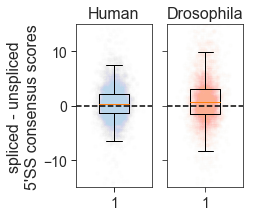

In [112]:
# get intron pair lengths
K562_splice_order_5SSMaxEnt_df = get_MaxEnt_score_5SS(K562_intron_pairs_df, hg38_intron_info)

S2_splice_order_5SSMaxEnt_df = get_MaxEnt_score_5SS(S2_intron_pairs_df, dm6_intron_info)

# plot distribution of intron lengths by splicing order

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(3,3))

# plotting length by splicing order K562 cells
y = K562_splice_order_5SSMaxEnt_df['splice_1']-K562_splice_order_5SSMaxEnt_df['splice_2']
x = np.random.normal(1, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax1.plot(x, y, '.', color=sns.color_palette("Blues")[1], alpha=0.01)

#y = K562_splice_order_3SSMaxEnt_df['splice_2']
#x = np.random.normal(2, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
#ax1.plot(x, y, '.', color=sns.color_palette("Blues")[1], alpha=0.01)

plot_list = [K562_splice_order_5SSMaxEnt_df['splice_1']-K562_splice_order_5SSMaxEnt_df['splice_2']]
ax1.boxplot(plot_list, 0, '', widths=0.4)

# plotting length by splicing order S2 cells
y = S2_splice_order_5SSMaxEnt_df['splice_1']-S2_splice_order_5SSMaxEnt_df['splice_2']
x = np.random.normal(1, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax2.plot(x, y, '.', color=sns.color_palette("Reds")[1], alpha=0.01)

#y = S2_splice_order_3SSMaxEnt_df['splice_2']
#x = np.random.normal(2, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
#ax2.plot(x, y, '.', color=sns.color_palette("Reds")[1], alpha=0.01)

plot_list = [S2_splice_order_5SSMaxEnt_df['splice_1']-S2_splice_order_5SSMaxEnt_df['splice_2']]
ax2.boxplot(plot_list, 0, '', widths=0.4)

ax1.axhline(y=0, color='black', linestyle='--')
ax2.axhline(y=0, color='black', linestyle='--')

ax1.set_ylabel("spliced - unspliced\n5'SS consensus scores", fontsize=16)
ax1.set_title("Human", fontsize=16)
plt.title("Drosophila", fontsize=16)
    
plt.xticks(fontsize=14)
plt.ylim(-15,15)

ax1.xaxis.set_tick_params(labelsize=14, direction='out', length=5, width=1)
ax1.yaxis.set_tick_params(labelsize=14, direction='out', length=5, width=1)
ax1.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax2.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.savefig('/path/to/Supplemental_Figure_6J_K562_S2_5SS_score_splicing_order_dif_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [113]:
print('K562 5\'SS (spliced>unspliced percent): '+str(float(len(K562_splice_order_5SSMaxEnt_df[(K562_splice_order_5SSMaxEnt_df['splice_1']-K562_splice_order_5SSMaxEnt_df['splice_2'])>0]))/float(len(K562_splice_order_5SSMaxEnt_df))))
print('S2 5\'SS (spliced>unspliced percent): '+str(float(len(S2_splice_order_5SSMaxEnt_df[(S2_splice_order_5SSMaxEnt_df['splice_1']-S2_splice_order_5SSMaxEnt_df['splice_2'])>0]))/float(len(S2_splice_order_5SSMaxEnt_df))))


K562 5'SS (spliced>unspliced percent): 0.560160427807
S2 5'SS (spliced>unspliced percent): 0.5817381317


In [114]:
### Supplemental Fig 6K

In [115]:
def get_MaxEnt_score_3SS(intron_pairs_df, intron_info):
    
    MaxEnt3SS_1 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int1_start','int1_end','strand'], right_on=['chrom','start','end','strand'], how='left')['MaxEnt_score_3SS']
    MaxEnt3SS_2 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int2_start','int2_end','strand'], right_on=['chrom','start','end','strand'], how='left')['MaxEnt_score_3SS']

    combined = pd.concat([intron_pairs_df['read'],intron_pairs_df['int1_splice'],intron_pairs_df['int2_splice'],MaxEnt3SS_1,MaxEnt3SS_2,intron_pairs_df['strand']],axis=1)
    combined.columns = ['read','int1_splice','int2_splice','int1_MaxEnt3SS','int2_MaxEnt3SS','strand']

    combined = combined[(combined['int1_MaxEnt3SS']>-100) & (combined['int2_MaxEnt3SS']>-100)].reset_index(drop=True)
    
    txn = combined[combined['int1_splice']!=combined['int2_splice']].reset_index(drop=True)
    txn = txn[txn['int1_MaxEnt3SS']!=txn['int2_MaxEnt3SS']].reset_index(drop=True)
    txn_pos = pd.concat([txn[txn['strand']=='+']['int1_splice'],txn[txn['strand']=='+']['int2_splice'],txn[txn['strand']=='+']['int1_MaxEnt3SS'],txn[txn['strand']=='+']['int2_MaxEnt3SS']], axis=1).reset_index(drop=True)
    txn_neg = pd.concat([txn[txn['strand']=='-']['int2_splice'],txn[txn['strand']=='-']['int1_splice'],txn[txn['strand']=='-']['int2_MaxEnt3SS'],txn[txn['strand']=='-']['int1_MaxEnt3SS']], axis=1).reset_index(drop=True)
    txn_neg.columns = ['int1_splice','int2_splice','int1_MaxEnt3SS','int2_MaxEnt3SS']
    txn_all = pd.concat([txn_pos,txn_neg]).reset_index(drop=True)

    txn_order = pd.concat([txn_all['int1_MaxEnt3SS'],txn_all['int2_MaxEnt3SS']], axis=1)
    txn_order.columns = ['txn_1','txn_2']

    int_1_splice = txn_all[txn_all['int1_splice']=="YES"].reset_index(drop=True)
    int_1_splice_MaxEnt3SS = pd.concat([int_1_splice['int1_MaxEnt3SS'],int_1_splice['int2_MaxEnt3SS']], axis=1)
    int_1_splice_MaxEnt3SS.columns = ['splice_1_MaxEnt3SS','splice_2_MaxEnt3SS']

    int_2_splice = txn_all[txn_all['int2_splice']=="YES"].reset_index(drop=True)
    int_2_splice_MaxEnt3SS = pd.concat([int_2_splice['int2_MaxEnt3SS'],int_2_splice['int1_MaxEnt3SS']], axis=1)
    int_2_splice_MaxEnt3SS.columns = ['splice_1_MaxEnt3SS','splice_2_MaxEnt3SS']

    MaxEnt3SSscore_splice_order = pd.concat([int_1_splice_MaxEnt3SS,int_2_splice_MaxEnt3SS]).reset_index(drop=True)
    MaxEnt3SSscore_splice_order.columns = ['splice_1','splice_2']

    return MaxEnt3SSscore_splice_order


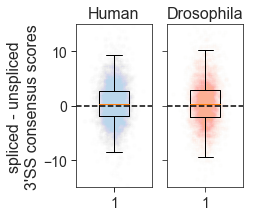

In [116]:
# get intron pair lengths
K562_splice_order_3SSMaxEnt_df = get_MaxEnt_score_3SS(K562_intron_pairs_df, hg38_intron_info)

S2_splice_order_3SSMaxEnt_df = get_MaxEnt_score_3SS(S2_intron_pairs_df, dm6_intron_info)

# plot distribution of intron lengths by splicing order

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(3,3))

# plotting length by splicing order K562 cells
y = K562_splice_order_3SSMaxEnt_df['splice_1']-K562_splice_order_3SSMaxEnt_df['splice_2']
x = np.random.normal(1, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax1.plot(x, y, '.', color=sns.color_palette("Blues")[1], alpha=0.01)

#y = K562_splice_order_3SSMaxEnt_df['splice_2']
#x = np.random.normal(2, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
#ax1.plot(x, y, '.', color=sns.color_palette("Blues")[1], alpha=0.01)

plot_list = [K562_splice_order_3SSMaxEnt_df['splice_1']-K562_splice_order_3SSMaxEnt_df['splice_2']]
ax1.boxplot(plot_list, 0, '', widths=0.4)

# plotting length by splicing order S2 cells
y = S2_splice_order_3SSMaxEnt_df['splice_1']-S2_splice_order_3SSMaxEnt_df['splice_2']
x = np.random.normal(1, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
ax2.plot(x, y, '.', color=sns.color_palette("Reds")[1], alpha=0.01)

#y = S2_splice_order_3SSMaxEnt_df['splice_2']
#x = np.random.normal(2, 0.1, size=len(y)) # Add some random "jitter" to the x-axis
#ax2.plot(x, y, '.', color=sns.color_palette("Reds")[1], alpha=0.01)

plot_list = [S2_splice_order_3SSMaxEnt_df['splice_1']-S2_splice_order_3SSMaxEnt_df['splice_2']]
ax2.boxplot(plot_list, 0, '', widths=0.4)

ax1.axhline(y=0, color='black', linestyle='--')
ax2.axhline(y=0, color='black', linestyle='--')

ax1.set_ylabel("spliced - unspliced\n3'SS consensus scores", fontsize=16)
ax1.set_title("Human", fontsize=16)
plt.title("Drosophila", fontsize=16)
    
plt.xticks(fontsize=14)
plt.ylim(-15,15)

ax1.xaxis.set_tick_params(labelsize=14, direction='out', length=5, width=1)
ax1.yaxis.set_tick_params(labelsize=14, direction='out', length=5, width=1)
ax1.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax2.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.savefig('/path/to/Supplemental_Figure_6K_K562_S2_3SS_score_splicing_order_dif_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [117]:
print('K562 3\'SS (spliced>unspliced percent): '+str(float(len(K562_splice_order_3SSMaxEnt_df[(K562_splice_order_3SSMaxEnt_df['splice_1']-K562_splice_order_3SSMaxEnt_df['splice_2'])>0]))/float(len(K562_splice_order_3SSMaxEnt_df))))
print('S2 3\'SS (spliced>unspliced percent): '+str(float(len(S2_splice_order_3SSMaxEnt_df[(S2_splice_order_3SSMaxEnt_df['splice_1']-S2_splice_order_3SSMaxEnt_df['splice_2'])>0]))/float(len(S2_splice_order_3SSMaxEnt_df))))


K562 3'SS (spliced>unspliced percent): 0.544941020103
S2 3'SS (spliced>unspliced percent): 0.530072325847


In [2]:
### Supplementary Fig. 6L and Table S3

In [34]:
def get_intron_order_eclip(intron_pairs_df, intron_info, RBP):
    
    # Getting eCLIP data for each intron within the pair
    eclip1 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int1_start','int1_end','strand'], right_on=['chrom','start','end','strand'], how='left')[RBP]
    eclip2 = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int2_start','int2_end','strand'], right_on=['chrom','start','end','strand'], how='left')[RBP]
    
    # Combining data from intron_pairs and from eCLIP density profiles (in a specific order of columns)
    combined = pd.concat([intron_pairs_df['read'],intron_pairs_df[['chrom','int1_start','int1_end','int1_splice']],intron_pairs_df[['int2_start','int2_end','int2_splice']],eclip1,eclip2,intron_pairs_df['strand']],axis=1)
    combined.columns = ['read','chrom','int1_start','int1_end','int1_splice','int2_start','int2_end','int2_splice','int1_RBP','int2_RBP','strand']

    # get eclip info by splicing order
    # select intermediate reads where the two introns have different splicing statuses
    combined = combined[combined['int1_splice']!=combined['int2_splice']].reset_index(drop=True) 
    # select intron pairs where "intron 1" (in physical distance) in first spliced
    int_1_splice = combined[combined['int1_splice']=="YES"].reset_index(drop=True)
    # retrieve the RBP density for the two introns within that pair and order the introns by splicing order
    int_1_splice_eclip = pd.concat([int_1_splice['int1_RBP'],int_1_splice['int2_RBP']], axis=1)
    int_1_splice_eclip.columns = ['splice_1_RBP','splice_2_RBP']

    # select intron pairs where "intron 2" (in physical distance) is first spliced
    int_2_splice = combined[combined['int2_splice']=="YES"].reset_index(drop=True)
    # retrieve the RBP density for the two introns within that pair and order the introns by splicing order
    int_2_splice_eclip = pd.concat([int_2_splice['int2_RBP'],int_2_splice['int1_RBP']], axis=1)
    int_2_splice_eclip.columns = ['splice_1_RBP','splice_2_RBP']

    splice_order = pd.concat([int_1_splice_eclip,int_2_splice_eclip]).reset_index(drop=True)
    splice_order.columns = ['splice_1','splice_2']
    
    return splice_order


def get_intron_order_eclip(intron_pairs_df, intron_info, RBP):

    # Getting eCLIP data for each intron within the pair
    eclip1_df = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int1_start','int1_end','strand'], right_on=['chrom','start','end','strand'], how='left')
    eclip1 = eclip1_df[RBP]/(eclip1_df['int1_end']-eclip1_df['int1_start'])
    eclip2_df = pd.merge(intron_pairs_df, intron_info, left_on=['chrom','int2_start','int2_end','strand'], right_on=['chrom','start','end','strand'], how='left')
    eclip2 = eclip2_df[RBP]/(eclip2_df['int2_end']-eclip2_df['int2_start'])

    # Combining data from intron_pairs and from eCLIP density profiles (in a specific order of columns)
    combined = pd.concat([intron_pairs_df['read'],intron_pairs_df[['chrom','int1_start','int1_end','int1_splice']],intron_pairs_df[['int2_start','int2_end','int2_splice']],eclip1,eclip2,intron_pairs_df['strand']],axis=1)
    combined.columns = ['read','chrom','int1_start','int1_end','int1_splice','int2_start','int2_end','int2_splice','int1_RBP','int2_RBP','strand']

    # get eclip info by splicing order
    # select intermediate reads where the two introns have different splicing statuses
    combined = combined[combined['int1_splice']!=combined['int2_splice']].reset_index(drop=True) 
    # select intron pairs where "intron 1" (in physical distance) in first spliced
    int_1_splice = combined[combined['int1_splice']=="YES"].reset_index(drop=True)
    # retrieve the RBP density for the two introns within that pair and order the introns by splicing order
    int_1_splice_eclip = pd.concat([int_1_splice['int1_RBP'],int_1_splice['int2_RBP']], axis=1)
    int_1_splice_eclip.columns = ['splice_1_RBP','splice_2_RBP']

    # select intron pairs where "intron 2" (in physical distance) is first spliced
    int_2_splice = combined[combined['int2_splice']=="YES"].reset_index(drop=True)
    # retrieve the RBP density for the two introns within that pair and order the introns by splicing order
    int_2_splice_eclip = pd.concat([int_2_splice['int2_RBP'],int_2_splice['int1_RBP']], axis=1)
    int_2_splice_eclip.columns = ['splice_1_RBP','splice_2_RBP']

    splice_order = pd.concat([int_1_splice_eclip,int_2_splice_eclip]).reset_index(drop=True)
    splice_order.columns = ['splice_1','splice_2']

    return splice_order


In [35]:
# upload files from directory
K562_1_intron_pairs_df = pd.read_table("/path/to/K562_1_hg38_intron_pairs_df.txt",header=0)
K562_2_intron_pairs_df = pd.read_table("/path/to/K562_2_hg38_intron_pairs_df.txt",header=0)
K562_3_intron_pairs_df = pd.read_table("/path/to/K562_3_hg38_intron_pairs_df.txt",header=0)
K562_4_intron_pairs_df = pd.read_table("/path/to/K562_4_hg38_intron_pairs_df.txt",header=0)
K562_5a_intron_pairs_df = pd.read_table("/path/to/K562_5a_hg38_intron_pairs_df.txt",header=0)
K562_5b_intron_pairs_df = pd.read_table("/path/to/K562_5b_hg38_intron_pairs_df.txt",header=0)
K562_5_intron_pairs_df = pd.concat([K562_5a_intron_pairs_df,K562_5b_intron_pairs_df],axis=0)


# concatenate samples to get pairs for each cell line
K562_intron_pairs_df = pd.concat([K562_1_intron_pairs_df, K562_2_intron_pairs_df, K562_3_intron_pairs_df, K562_4_intron_pairs_df, K562_5_intron_pairs_df], axis=0).reset_index(drop=True)
K562_intron_pairs_df['chrom'] = 'chr'+K562_intron_pairs_df['chrom']


In [36]:
# read the dataframe to file for future use
intron_df_sum = pd.read_table('/path/to/annotation_files/K562_introns_wiRBP_sumFC.txt')
intron_df_count = pd.read_table('/path/to/annotation_files/K562_introns_wiRBP_peakCount.txt')


In [37]:
# Remove duplicate introns (i.e. same coordinates but different transcript)
hg38_intron_info_count = intron_df_count.drop_duplicates(subset=['chrom','start','end','strand'])
hg38_intron_info_sum = intron_df_sum.drop_duplicates(subset=['chrom','start','end','strand'])


In [38]:
# get intron pair RBP binding status (for mean eCLIP FC and number of peaks per intron)
rbp_list = hg38_intron_info_sum.columns[6:].tolist()

In [39]:
# Calculate number of introns with at least one peak for a given RBP
# Note: we are counting at the read level, so some introns may be counted multiple times

peak_numbers_list = []

for RBP in rbp_list:
    splice_order_RBP_count = get_intron_order_eclip(K562_intron_pairs_df, hg38_intron_info_count, RBP)
    splice_order_RBP_count['RBP'] = RBP
    
    # Count the number of introns that have at least one peak
    splice1_with_peaks = len(splice_order_RBP_count[splice_order_RBP_count['splice_1'] > 0])
    splice2_with_peaks = len(splice_order_RBP_count[splice_order_RBP_count['splice_2'] > 0])
    
    # Count the number of introns that have no peaks
    splice1_no_peaks = len(splice_order_RBP_count[splice_order_RBP_count['splice_1'] == 0])
    splice2_no_peaks = len(splice_order_RBP_count[splice_order_RBP_count['splice_2'] == 0])
    
    peak_numbers_list.append([RBP,splice1_with_peaks,splice2_with_peaks,splice1_no_peaks,splice2_no_peaks])
    
peak_numbers_df = pd.DataFrame(peak_numbers_list)
peak_numbers_df.columns = ['RBP','spliced_withPeaks','unspliced_withPeaks','spliced_noPeaks','unspliced_noPeaks']


In [40]:
# Compare density for each RBP using the Wilcoxon rank-sum test (to be consistent with the RBP figure in the main figure)

rbp_ranksum = {}

# sum eCLIP fold change
for RBP in rbp_list:
    splice_order_RBP_sum = get_intron_order_eclip(K562_intron_pairs_df, hg38_intron_info_sum, RBP)
    
    # Remove the intron pairs that have 0 binding for both introns
    splice_order_RBP_sum['RBP'] = RBP
    splice_order_RBP_sum = splice_order_RBP_sum[(splice_order_RBP_sum['splice_1'] > 0) |
                                               (splice_order_RBP_sum['splice_2'] > 0)].reset_index(drop=True)
    
    # Compare spliced and unspliced introns using a paired t-test
    if len(splice_order_RBP_sum) > 1:
        t1,p1 = scipy.stats.ranksums(splice_order_RBP_sum['splice_1'], splice_order_RBP_sum['splice_2'])
        mean_spliced = np.mean(splice_order_RBP_sum['splice_1'])
        mean_unspliced = np.mean(splice_order_RBP_sum['splice_2'])
        mean_both = np.mean([mean_spliced,mean_unspliced])
        
        # Add the stats to a dictionary
        rbp_ranksum[RBP] = [t1,p1,mean_spliced,mean_unspliced,mean_both]
    
# Make a dataframe for easier filtering from the t-test outputs
rbp_ranksum_df = pd.DataFrame.from_dict(rbp_ranksum,orient='index')
rbp_ranksum_df.columns = ['statistic', 'pvalue', 'mean_spliced', 'mean_unspliced','mean_both']

In [41]:
# Correct for multiple testing using Bonferroni
padj_threshold_ranksum = 0.05 / len(rbp_ranksum_df)

rbp_sig = rbp_ranksum_df[rbp_ranksum_df['pvalue'] < padj_threshold_ranksum].copy()
rbp_sig['RBP'] = rbp_sig.index

# Add number of introns with peaks
rbp_sig_peak_numbers = peak_numbers_df[peak_numbers_df['RBP'].isin(rbp_sig.index)].reset_index(drop=True)

rbp_sig = rbp_sig_peak_numbers.merge(rbp_sig, on='RBP', how='inner')

# Remove RBPs that have less than count_thresh introns with peaks
count_thresh = 5
rbp_sig = rbp_sig[(rbp_sig['spliced_withPeaks'] > count_thresh) & (rbp_sig['unspliced_withPeaks'] > count_thresh)]

# Sort by p-value
rbp_sig = rbp_sig.sort_values(by='pvalue').reset_index(drop=True)

rbp_sig2 = rbp_sig[['RBP', 'spliced_withPeaks', 'unspliced_withPeaks', 'mean_spliced', 'mean_unspliced', 'mean_both','pvalue']]
rbp_sig2.columns = ['RBP', 'N_spliced_with_peaks','N_unspliced_with_peaks', 'mean_spliced', 'mean_unspliced', 'mean_both','pvalue']


In [42]:
padj_threshold_ranksum

0.0004950495049504951

In [43]:
len(rbp_ranksum_df)

101

In [44]:
# Add number of introns with peaks to total ranksum dataframe
rbp_ranksum_df['RBP'] = rbp_ranksum_df.index

rbp_ranksum_peak_numbers = peak_numbers_df[peak_numbers_df['RBP'].isin(rbp_ranksum_df.index)].reset_index(drop=True)

rbp_ranksum_df2 = rbp_ranksum_peak_numbers.merge(rbp_ranksum_df, on='RBP', how='inner')
rbp_ranksum_df2 = rbp_ranksum_df2[['RBP','spliced_withPeaks','unspliced_withPeaks','mean_spliced','mean_unspliced','mean_both','pvalue',]].sort_values(by='pvalue').reset_index(drop=True)

In [45]:
# Use chisquare test to compare the number of introns with/without peaks
chisquare_test_list = []

for i in range(len(peak_numbers_df)):
    RBP = peak_numbers_df.loc[i]['RBP']
    spliced_withPeaks = peak_numbers_df.loc[i]['spliced_withPeaks']
    unspliced_withPeaks = peak_numbers_df.loc[i]['unspliced_withPeaks']
    spliced_noPeaks = peak_numbers_df.loc[i]['spliced_noPeaks']
    unspliced_noPeaks = peak_numbers_df.loc[i]['unspliced_noPeaks']
    
    if (spliced_withPeaks > 0) and (unspliced_withPeaks > 0):
        pvalue = scipy.stats.chi2_contingency(np.array([[spliced_withPeaks,unspliced_withPeaks],[spliced_noPeaks,unspliced_noPeaks]]))[1]
        delta = unspliced_withPeaks - spliced_withPeaks
        fc = unspliced_withPeaks / spliced_withPeaks
        mean = np.mean([unspliced_withPeaks,spliced_withPeaks])
        total = np.sum([unspliced_withPeaks,spliced_withPeaks])
        chisquare_test_list.append([RBP,pvalue,delta,fc,mean,total])
        
chisquare_test_df = pd.DataFrame(chisquare_test_list)

chisquare_test_df.columns = ['RBP','pvalue','delta','fc','mean','total']


In [46]:
# Add RBP function to dataframe

ann_df = pd.read_csv('/path/to/annotation_files/functions_rbps.txt', sep='\t')

# Make an summarized annotation for our purposes
ann_df['main_annotation'] = 'other'
ann_df.loc[ann_df['Spliceosome'] == 1, 'main_annotation'] = 'spliceosome'
ann_df.loc[(ann_df['Spliceosome'] == 0) & (ann_df['Splicing_regulation'] == 1), 'main_annotation'] = 'splicing_regulation'

# Merge with the chi-squared result
chisquare_test_df = chisquare_test_df.merge(ann_df[['RBP_name','main_annotation']], left_on='RBP', right_on='RBP_name', how='left')


In [47]:
# Add a significance annotation

padj_threshold_chi = 0.05/len(chisquare_test_df)

chisquare_test_df['significance'] = 'non_significant'
chisquare_test_df.loc[(chisquare_test_df['pvalue'] < padj_threshold_chi), 'significance'] = 'significant'

chisquare_test_df['final_group'] = chisquare_test_df['main_annotation']
chisquare_test_df.loc[chisquare_test_df['pvalue'] > padj_threshold_chi, 'final_group'] = 'non_significant'

chisquare_test_df = chisquare_test_df.sort_values(by='pvalue')

padj_threshold_chi

0.0006578947368421052

In [48]:
len(chisquare_test_df)

76

In [65]:
# Merge the results from the two different statistical tests (t-test and chi-square)
stats_df = rbp_ranksum_df2.merge(chisquare_test_df[['RBP','pvalue','fc','mean','total','main_annotation','significance']], on='RBP', how='inner').reset_index(drop=True)
stats_df.columns = ['RBP','spliced_withPeaks','unspliced_withPeaks','mean_spliced','mean_unspliced','mean_both','pvalue_ranksum',
                    'pvalue_chisquare','fc_N_peaks','mean_N_peaks','total_N_peaks','main_annotation','significance']


In [83]:
# Add an extra column that takes into account both p-value and number of peaks for significance
stats_df['significance2'] = 'non_significant'
stats_df.loc[(stats_df['pvalue_chisquare'] < padj_threshold_chi) & (stats_df['pvalue_ranksum'] < padj_threshold_ranksum) &
             (stats_df['spliced_withPeaks'] > 5) & (stats_df['unspliced_withPeaks'] > 5), 'significance2'] = 'significant'


In [84]:
# Filter for significance (after Bonferroni correction) and for a minimum number of peaks:
stats_df_sig = stats_df[((stats_df['pvalue_ranksum'] < padj_threshold_ranksum) & (stats_df['pvalue_chisquare'] < padj_threshold_chi)) &
        (stats_df['spliced_withPeaks'] > 5) & (stats_df['unspliced_withPeaks'] > 5)]

# This is the final table that would go into Supplemental:
stats_df_sig_final = stats_df_sig[['RBP','spliced_withPeaks','unspliced_withPeaks','mean_spliced','mean_unspliced',
                                  'pvalue_ranksum','pvalue_chisquare']].reset_index(drop=True)

stats_df_sig_final.columns = ['RBP','spliced_introns_with_peaks','unspliced_introns_with_peaks',
                             'mean_density_spliced','mean_density_unspliced','pvalue_ranksum','pvalue_chi-square']

stats_df_sig_final


,RBP,spliced_introns_with_peaks,unspliced_introns_with_peaks,mean_density_spliced,mean_density_unspliced,pvalue_ranksum,pvalue_chi-square
0,BUD13,251,736,0.008549,0.020046,3.809514e-76,3.606829e-58
1,PRPF8,839,1524,0.015096,0.021646,1.110147e-63,1.664065e-55
2,DDX24,45,269,0.003291,0.020524,8.854044e-54,3.042870e-37
3,UCHL5,34,221,0.002782,0.016505,7.703537e-47,5.375948e-32
4,SF3B4,1081,1710,0.020681,0.026350,3.056676e-37,6.789986e-42
5,RBFOX2,48,214,0.003842,0.017749,4.019687e-37,6.591549e-25
6,RBM15,37,190,0.005473,0.021332,6.542371e-33,2.313601e-24
7,TIA1,75,272,0.007603,0.015706,3.193791e-32,1.308305e-26
8,AQR,1340,1842,0.017806,0.022669,6.768275e-30,4.040577e-25
9,ZNF622,6,98,0.001366,0.019305,2.053537e-28,3.187007e-19


In [85]:
stats_df_sig_final_annotations = pd.merge(stats_df_sig_final,ann_df[['RBP_name','main_annotation']],left_on='RBP',right_on='RBP_name',how='left')
stats_df_sig_final_annotations.drop(['RBP_name'],axis=1)

,RBP,spliced_introns_with_peaks,unspliced_introns_with_peaks,mean_density_spliced,mean_density_unspliced,pvalue_ranksum,pvalue_chi-square,main_annotation
0,BUD13,251,736,0.008549,0.020046,3.809514e-76,3.606829e-58,spliceosome
1,PRPF8,839,1524,0.015096,0.021646,1.110147e-63,1.664065e-55,spliceosome
2,DDX24,45,269,0.003291,0.020524,8.854044e-54,3.042870e-37,other
3,UCHL5,34,221,0.002782,0.016505,7.703537e-47,5.375948e-32,other
4,SF3B4,1081,1710,0.020681,0.026350,3.056676e-37,6.789986e-42,spliceosome
5,RBFOX2,48,214,0.003842,0.017749,4.019687e-37,6.591549e-25,splicing_regulation
6,RBM15,37,190,0.005473,0.021332,6.542371e-33,2.313601e-24,splicing_regulation
7,TIA1,75,272,0.007603,0.015706,3.193791e-32,1.308305e-26,splicing_regulation
8,AQR,1340,1842,0.017806,0.022669,6.768275e-30,4.040577e-25,spliceosome
9,ZNF622,6,98,0.001366,0.019305,2.053537e-28,3.187007e-19,other


In [86]:
stats_df_sig_final_annotations.to_csv('/path/to/Supplementary_Table_eCLIP.csv', sep='\t')

In [92]:
n_sig_rbp = len(stats_df_sig_final_annotations)
print("number of significant RBPs:", n_sig_rbp)

n_spliceosome_rbp = len(stats_df_sig_final_annotations[stats_df_sig_final_annotations['main_annotation'] == 'spliceosome'])
print("number of significant RBPs - spliceosome:", n_spliceosome_rbp)

n_splicing_reg_rbp = len(stats_df_sig_final_annotations[stats_df_sig_final_annotations['main_annotation'] == 'splicing_regulation'])
print("number of significant RBPs - splicing regulation:", n_splicing_reg_rbp)

number of significant RBPs: 27
number of significant RBPs - spliceosome: 9
number of significant RBPs - splicing regulation: 6


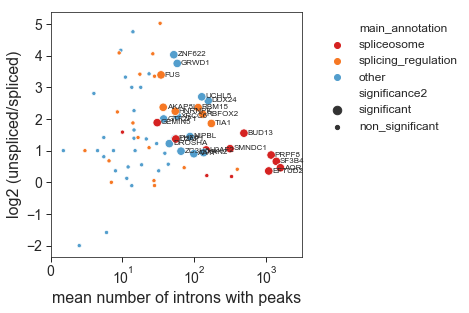

In [87]:
# Make MA plot with results from chi-square test and mean number of introns as x axis

fig, ax = plt.subplots(figsize=(4.5,4.5))

stats_df['log10_mean'] = np.log10(stats_df['mean_N_peaks'])
stats_df['log2_fc'] = np.log2(stats_df['fc_N_peaks'])

fill_colors = [sns.color_palette("Reds")[4],sns.color_palette("Oranges")[3],
               sns.color_palette("Blues")[3]]

sns.scatterplot(x='log10_mean', y='log2_fc', data=stats_df, hue='main_annotation', 
                size='significance2',palette=fill_colors,
               hue_order=['spliceosome','splicing_regulation','other'])


plt.yticks(fontsize=14)

plt.ylabel("log2 (unspliced/spliced)", fontsize=16)
plt.xlabel("mean number of introns with peaks", fontsize=16)

# Select significant ones for annotation
stats_df_sig = stats_df[stats_df['significance2'] == 'significant'].reset_index(drop=True)
x2 = np.log10(stats_df_sig['mean_N_peaks'])
y2 = np.log2(stats_df_sig['fc_N_peaks'])
names = stats_df_sig['RBP']

for i, txt in enumerate(names):
    ax.annotate(txt, (x2[i]+0.05, y2[i]-0.05), fontsize=8)
    
plt.xlim(0,3.5)

labels = ["0","$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$"]
plt.xticks([0,1,2,3], labels, fontsize=14)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=12, frameon=False)
  
plt.tick_params(axis='both', direction='out', length=5, width=1)

    
plt.savefig('/path/to/Supplemental_Figure_6L_K562_eCLIP_MA_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [22]:
### Supplementary Figure 6M

In [5]:
def calculate_psi(sample_name):
    # Calculate PSI for all introns
    rna_seq_1 = pd.read_csv('/path/to/%s_1_SI_counts.txt' %sample_name, sep='\t')
    rna_seq_1.columns = ['gene','intron','chrom','start','end','strand','count_5SS','count_3SS','splice_count']
    rna_seq_1['chrom'] = 'chr'+ rna_seq_1['chrom'].astype(str)

    rna_seq_2 = pd.read_csv('/path/to/%s_2_SI_counts.txt' %sample_name, sep='\t')
    rna_seq_2.columns = ['gene','intron','chrom','start','end','strand','count_5SS','count_3SS','splice_count']
    rna_seq_2['chrom'] = 'chr'+ rna_seq_2['chrom'].astype(str)

    # remove introns that have 0 in either the denominator or numerator of the PSI
    # Actually, for this purpose, I will remove only the introns that have 0 as the denominator (and therefore are fully spliced)
    rna_seq_1 = rna_seq_1[(rna_seq_1['count_5SS']+rna_seq_1['count_3SS'])>0].reset_index(drop=True)
    rna_seq_1['PSI'] = (2*rna_seq_1['splice_count']) / (rna_seq_1['count_5SS']+rna_seq_1['count_3SS'])

    rna_seq_2 = rna_seq_2[(rna_seq_2['count_5SS']+rna_seq_2['count_3SS'])>0].reset_index(drop=True)
    rna_seq_2['PSI'] = (2*rna_seq_2['splice_count']) / (rna_seq_2['count_5SS']+rna_seq_2['count_3SS'])

    # Merge the results from the two replicates
    fields = ['gene','intron','chrom','start','end','strand','PSI']
    rna_seq_df = pd.merge(rna_seq_1[fields],rna_seq_2[fields],on=['gene','intron','chrom','start','end','strand'],how='inner')
    rna_seq_df.columns = ['gene','intron','chrom','start','end','strand','PSI_rep1','PSI_rep2']

    # Calculate average of the two replicates
    rna_seq_df['PSI_avg'] = (rna_seq_df['PSI_rep1']+rna_seq_df['PSI_rep2'])/2
    
    return rna_seq_df
     

In [6]:
# Read eCLIP intron data
intron_df_sum = pd.read_csv('/path/to/annotation_files/K562_introns_wiRBP_sumFC.txt', sep='\t')

# Remove duplicate introns (i.e. same coordinates but different transcript)
hg38_intron_info_sum = intron_df_sum.drop_duplicates(subset=['chrom','start','end','strand'])

# Get total RBP density per intron (regardless of RBP identity)
rbp_list = hg38_intron_info_sum.columns[6:].tolist()
rbp_total_density = hg38_intron_info_sum.loc[:,rbp_list].sum(axis=1)

hg38_intron_info_total = pd.concat([hg38_intron_info_sum[['chrom','start','end','gene','intron_length','strand']],rbp_total_density],axis=1)
hg38_intron_info_total.columns = ['chrom','start','end','gene','intron_length','strand','RBP_density']

eclip_df = hg38_intron_info_total.copy()

In [7]:
# Calculate psi
tot_rna_df = calculate_psi("tot")
chr_rna_df = calculate_psi("chr")
lab_rna_df = calculate_psi("4su")
lab_chr_rna_df = calculate_psi("4suchr")

/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [8]:
# Merge the eCLIP data and the RNA-seq data
both_df = pd.merge(tot_rna_df,eclip_df,on=['chrom','start','end','strand','gene'], how='left')

both_df = both_df[both_df['RBP_density'] > 0].reset_index(drop=True)

both_df['log10_PSI'] = np.log10(both_df['PSI_avg']+1)
both_df['log10_RBP'] = np.log10(both_df['RBP_density'])

In [49]:
# Read files with intron pair information (previously produced, see script from 2018-12-05)
K562_1_intron_pairs_df = pd.read_table("/path/to/K562_1_hg38_intron_pairs_df.txt",header=0)
K562_2_intron_pairs_df = pd.read_table("/path/to/K562_2_hg38_intron_pairs_df.txt",header=0)
K562_3_intron_pairs_df = pd.read_table("/path/to/K562_3_hg38_intron_pairs_df.txt",header=0)
K562_4_intron_pairs_df = pd.read_table("/path/to/K562_4_hg38_intron_pairs_df.txt",header=0)
K562_5a_intron_pairs_df = pd.read_table("/path/to/K562_5a_hg38_intron_pairs_df.txt",header=0)
K562_5b_intron_pairs_df = pd.read_table("/path/to/K562_5b_hg38_intron_pairs_df.txt",header=0)
K562_5_intron_pairs_df = pd.concat([K562_5a_intron_pairs_df,K562_5b_intron_pairs_df],axis=0)

# concatenate samples to get pairs for each cell line
K562_intron_pairs_df = pd.concat([K562_1_intron_pairs_df, K562_2_intron_pairs_df, K562_3_intron_pairs_df, K562_4_intron_pairs_df, K562_5_intron_pairs_df], axis=0).reset_index(drop=True)
K562_intron_pairs_df['chrom'] = 'chr'+K562_intron_pairs_df['chrom']

In [12]:
# Get splicing order and RBP density
splice_order_RBP_total = get_intron_order_eclip(K562_intron_pairs_df, hg38_intron_info_total, 'RBP_density')
splice_order_RBP_total = splice_order_RBP_total.drop_duplicates().reset_index(drop=True)

In [13]:
# Start by getting all the introns that were used in the analysis, regardless of whether they were 1st or 2nd
interm_pairs_df = K562_intron_pairs_df[K562_intron_pairs_df['int1_splice'] != K562_intron_pairs_df['int2_splice']]

pair1 = interm_pairs_df[['chrom','int1_start','int1_end','strand']]
pair1.columns = ['chrom','start','end','strand']
pair2 = interm_pairs_df[['chrom','int2_end','int2_end','strand']]
pair2.columns = ['chrom','start','end','strand']

interm_pairs_coord = pd.concat([pair1,pair2]).drop_duplicates().reset_index(drop=True)

# Merge with PSI/eCLIP dataframe
nanocop_pairs_df = pd.merge(interm_pairs_coord,both_df,on=['chrom','start','end','strand'],how='inner')

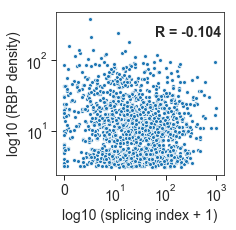

In [118]:
fig, ax = plt.subplots(figsize=(3,3))

sns.scatterplot(x="log10_PSI", y="log10_RBP", data=nanocop_pairs_df, s=15)

ax.tick_params(axis='both', direction='out', length=5, width=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("log10 (splicing index + 1)", fontsize=14)
plt.ylabel("log10 (RBP density)", fontsize=14)

x_labels = ["0","$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$"]
plt.xticks([0,1,2,3], x_labels, fontsize=14)

y_labels = ["$\mathregular{10^{1}}$","$\mathregular{10^{2}}$"]
plt.yticks([1,2], y_labels, fontsize=14)

plt.text(1.8, 2.5, 'R = -0.104', horizontalalignment='left', verticalalignment='top', fontsize=14, weight='bold')

plt.savefig('/path/to/Supplemental_Figure_6K_K562_eCLIP_vs_splicing_index.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [119]:
scipy.stats.pearsonr(nanocop_pairs_df['log10_PSI'],nanocop_pairs_df['log10_RBP'])

(-0.10370557553546997, 1.4445423752838122e-05)